# Week HW 18

Last Audit: HW18

# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
#####################

salvage_value = 0
cost = 500
price = 1000
holding_cost = 20

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

data_size = 20
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 400
MIPGAP = 0.3
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [266]:
show_models("linear_constraint_med_with_holding_cost")

Contents of models/linear_constraint_med_with_holding_cost_20_s2_10_202411261642.pkl:
{'alpha': array([0.4340641 , 0.04226074, 2.0744787 ])}

Contents of models/linear_constraint_med_with_holding_cost_20_s3_10_202411261642.pkl:
{'beta': array([[ 0.52353619],
       [-0.55833544],
       [ 1.50958726],
       [ 0.59536325],
       [ 1.95088368],
       [ 2.10002145],
       [ 0.807121  ],
       [ 0.61603921]]), 'tau_values': array([[-6.26324958e-01, -5.66683093e-01, -1.84714842e+00,
        -6.08383462e+00, -2.11291667e+00, -2.50506088e+00,
        -6.79959287e+00, -2.88130093e+00],
       [-8.89168193e-02, -1.43146473e+00, -4.12787650e+00,
        -9.16648578e-01, -2.77342910e+00, -4.47407216e-01,
        -1.30644662e-01, -6.62065336e+00],
       [-1.38487803e+00, -8.27401439e-02, -8.30307545e+00,
        -1.86898512e+00, -7.90742759e+00, -5.65701631e+00,
        -1.46017142e+00, -8.64592551e+00],
       [-1.20534716e+00, -2.26144447e-01, -7.15422977e+00,
        -2.41559180e+00, -6.7

In [265]:
show_models("med_with_holding_cost")

Contents of models/med_with_holding_cost_20_s2_20_202411261501.pkl:
{'alpha': array([1.86151667, 0.06004136, 4.36040795])}



## Visualization 

In [7]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [8]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [10]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [11]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [12]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [13]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [14]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [15]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [16]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(100, 150, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
    }
)

full_df

,X1,X2
0,127.440675,-10.427633
1,135.759468,-14.016829
2,130.138169,-20.770413
3,127.244159,-14.389416
4,121.182740,-27.634511
5,132.294706,-17.201580
6,121.879361,-27.132934
7,144.588650,-11.106622
8,148.183138,-19.563034
9,119.172076,-21.706761


In [17]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (10, 2), Test size: (10, 2)
Train (normalized):
         X1        X2
0  0.801348  0.060576
1 -1.322677 -2.263356
2 -0.168380 -0.782220
3  1.709838  1.200776
4 -1.510442 -0.043531
Test (normalized):
         X1        X2
0  1.290041  1.197330
1  1.057385  0.656356
2  1.629435  0.217340
3  1.975462 -0.381187
4  1.340174 -1.343835

Fold 2:
Train size: (10, 2), Test size: (10, 2)
Train (normalized):
         X1        X2
0  1.155422 -0.504766
1 -0.317164  1.763667
2  0.938181  0.122292
3  0.579181  1.570825
4 -0.963489 -1.355168
Test (normalized):
         X1        X2
0 -0.332525  0.668179
1 -2.383078 -0.263304
2 -0.751871 -2.855580
3  0.632210 -2.185297
4 -0.106311 -1.096254



## Data2: demand_df


### mu of each time(t)


In [19]:
# 設定 b0, b1, b2
b0 = 0.3
b1 = 0.17
b2 = 0.2


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 * random_noises[t - 1]
        )

    return mu_matrix

In [20]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (20, 10)
mu_matrix[0]: 
[20.10860386 19.69943531 19.87300955 20.25165611 20.13965555 19.28620479
 19.86441468 19.53398099 19.5484225  19.7025677 ]


### sigma matrix


In [21]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.12593609  0.39526239 -0.87954906  0.33353343  0.34127574 -0.57923488
  -0.7421474  -0.3691433  -0.27257846  0.14039354]
 [-0.12279697  0.97674768 -0.79591038 -0.58224649 -0.67738096  0.30621665
  -0.49341679 -0.06737845 -0.51114882 -0.68206083]]


In [22]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((20, 10),
 array([[6.33962255, 8.57873649, 4.30896461, 5.94552029, 5.76807482,
         6.67602145, 4.96290496, 6.18183316, 5.42343077, 5.54020243],
        [6.3417756 , 8.44618042, 4.30321694, 6.26509127, 6.12445957,
         6.37878351, 4.89804711, 6.0832969 , 5.51455209, 5.82978508],
        [6.4519222 , 7.92390401, 4.94931996, 6.57960146, 6.50256833,
         6.30277772, 5.37411811, 6.21161838, 5.91865713, 6.25838967],
        [6.38884974, 8.33631163, 4.58232804, 6.17345972, 6.03349463,
         6.56206346, 5.15300694, 6.21135712, 5.62513907, 5.80742419],
        [6.57916252, 7.24252343, 5.78569915, 6.85070621, 6.83547072,
         6.30009478, 5.97347039, 6.38906489, 6.36611822, 6.6702511 ],
        [6.39785249, 8.20429894, 4.62283156, 6.4033117 , 6.2924086 ,
         6.36168537, 5.1423411 , 6.15584812, 5.71320538, 6.02744396],
        [6.56969352, 7.29648329, 5.72151549, 6.83167648, 6.81204214,
         6.29931802, 5.9280493 , 6.37552407, 6.3331389 , 6.64076637],
        [6.26202

### corr matrix


In [23]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [24]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (20, 10, 10)
cov_matrices: 
[[ 40.19081404  19.26583117  15.1824569   22.14089021 -14.1798824
   -6.83457249  -3.11712204 -10.81436697 -16.80930612  -0.73493371]
 [ 19.26583117  73.59471973  23.86754584  17.55842895 -26.42194581
   -6.79898946 -15.6081998    3.83053217   5.11593378  -2.3348731 ]
 [ 15.1824569   23.86754584  18.56717602   6.65398111 -10.64991617
   -6.80392192 -11.79474146   0.28135771  -9.68067088  -3.07260357]
 [ 22.14089021  17.55842895   6.65398111  35.34921148 -14.87393057
   -3.134176     4.90503621 -23.19270162   2.87430238   8.04303616]
 [-14.1798824  -26.42194581 -10.64991617 -14.87393057  33.27068713
   14.30175679   8.59680608  10.4839412   -4.80876272  -3.46881088]
 [ -6.83457249  -6.79898946  -6.80392192  -3.134176    14.30175679
   44.56926245  21.81082318  21.48137613 -12.37327815   5.4525029 ]
 [ -3.11712204 -15.6081998  -11.79474146   4.90503621   8.59680608
   21.81082318  24.63042563   1.19471563  -0.26302138  13.35924634]
 [-10.81

In [25]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [26]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,18.931140,5.655496,17.448441,19.474777,36.115151,31.347239,25.494239,18.068743,7.942163,11.095672
1,19.035358,24.938871,24.988579,21.016072,21.913622,29.943983,22.684565,26.280003,15.311041,20.699825
2,26.183389,41.405609,27.108087,31.633282,3.037348,20.578618,16.125933,15.086051,17.950771,9.731303
3,9.322770,23.793592,20.131964,16.040927,16.910710,18.810361,14.524609,26.519531,26.636471,23.458608
4,21.993667,8.729794,9.197501,23.579945,8.661085,1.078679,11.170736,-2.297169,22.638680,13.578989
5,18.983674,30.433868,22.754177,19.626266,15.445056,14.812940,14.774223,20.215903,23.568330,20.972546
6,15.863114,25.747472,13.698376,15.399413,7.411775,11.652727,12.016384,18.596598,25.421089,19.100295
7,26.678838,14.281307,19.702800,22.965390,26.224115,28.989238,28.705340,20.867050,15.440646,19.501281
8,19.089756,33.186363,16.855376,28.555372,9.163415,21.527857,23.665532,15.565365,31.889307,22.068575
9,21.401028,19.942260,22.019712,14.568653,20.305671,14.752316,14.939508,14.518569,6.879041,9.120182


### Replace negative values to 0


In [27]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,18.931140,5.655496,17.448441,19.474777,36.115151,31.347239,25.494239,18.068743,7.942163,11.095672
1,19.035358,24.938871,24.988579,21.016072,21.913622,29.943983,22.684565,26.280003,15.311041,20.699825
2,26.183389,41.405609,27.108087,31.633282,3.037348,20.578618,16.125933,15.086051,17.950771,9.731303
3,9.322770,23.793592,20.131964,16.040927,16.910710,18.810361,14.524609,26.519531,26.636471,23.458608
4,21.993667,8.729794,9.197501,23.579945,8.661085,1.078679,11.170736,0.000000,22.638680,13.578989
5,18.983674,30.433868,22.754177,19.626266,15.445056,14.812940,14.774223,20.215903,23.568330,20.972546
6,15.863114,25.747472,13.698376,15.399413,7.411775,11.652727,12.016384,18.596598,25.421089,19.100295
7,26.678838,14.281307,19.702800,22.965390,26.224115,28.989238,28.705340,20.867050,15.440646,19.501281
8,19.089756,33.186363,16.855376,28.555372,9.163415,21.527857,23.665532,15.565365,31.889307,22.068575
9,21.401028,19.942260,22.019712,14.568653,20.305671,14.752316,14.939508,14.518569,6.879041,9.120182


### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [28]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,198.007951,191.573061,20.551797,9.239292,122.439096
1,204.971508,226.811918,20.559220,3.886124,429.041846
2,181.908131,208.840390,21.074002,10.542032,99.904553
3,189.750307,196.149543,20.779188,5.310852,291.259008
4,152.955704,120.629075,21.672147,8.020369,170.213846
5,192.711910,201.586982,20.820191,4.539373,358.657821
6,155.143114,164.907241,21.627783,5.584968,287.249890
7,225.801531,223.356006,20.198450,4.987575,304.975343
8,214.999337,221.566917,20.599238,7.139897,188.508915
9,161.393076,158.446939,21.387383,4.865137,339.604929


### Validate normal distribution


In [29]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,18.931140,5.655496,17.448441,19.474777,36.115151,31.347239,25.494239,18.068743,7.942163,11.095672
1,19.035358,24.938871,24.988579,21.016072,21.913622,29.943983,22.684565,26.280003,15.311041,20.699825
2,26.183389,41.405609,27.108087,31.633282,3.037348,20.578618,16.125933,15.086051,17.950771,9.731303
3,9.322770,23.793592,20.131964,16.040927,16.910710,18.810361,14.524609,26.519531,26.636471,23.458608
4,21.993667,8.729794,9.197501,23.579945,8.661085,1.078679,11.170736,0.000000,22.638680,13.578989
5,18.983674,30.433868,22.754177,19.626266,15.445056,14.812940,14.774223,20.215903,23.568330,20.972546
6,15.863114,25.747472,13.698376,15.399413,7.411775,11.652727,12.016384,18.596598,25.421089,19.100295
7,26.678838,14.281307,19.702800,22.965390,26.224115,28.989238,28.705340,20.867050,15.440646,19.501281
8,19.089756,33.186363,16.855376,28.555372,9.163415,21.527857,23.665532,15.565365,31.889307,22.068575
9,21.401028,19.942260,22.019712,14.568653,20.305671,14.752316,14.939508,14.518569,6.879041,9.120182


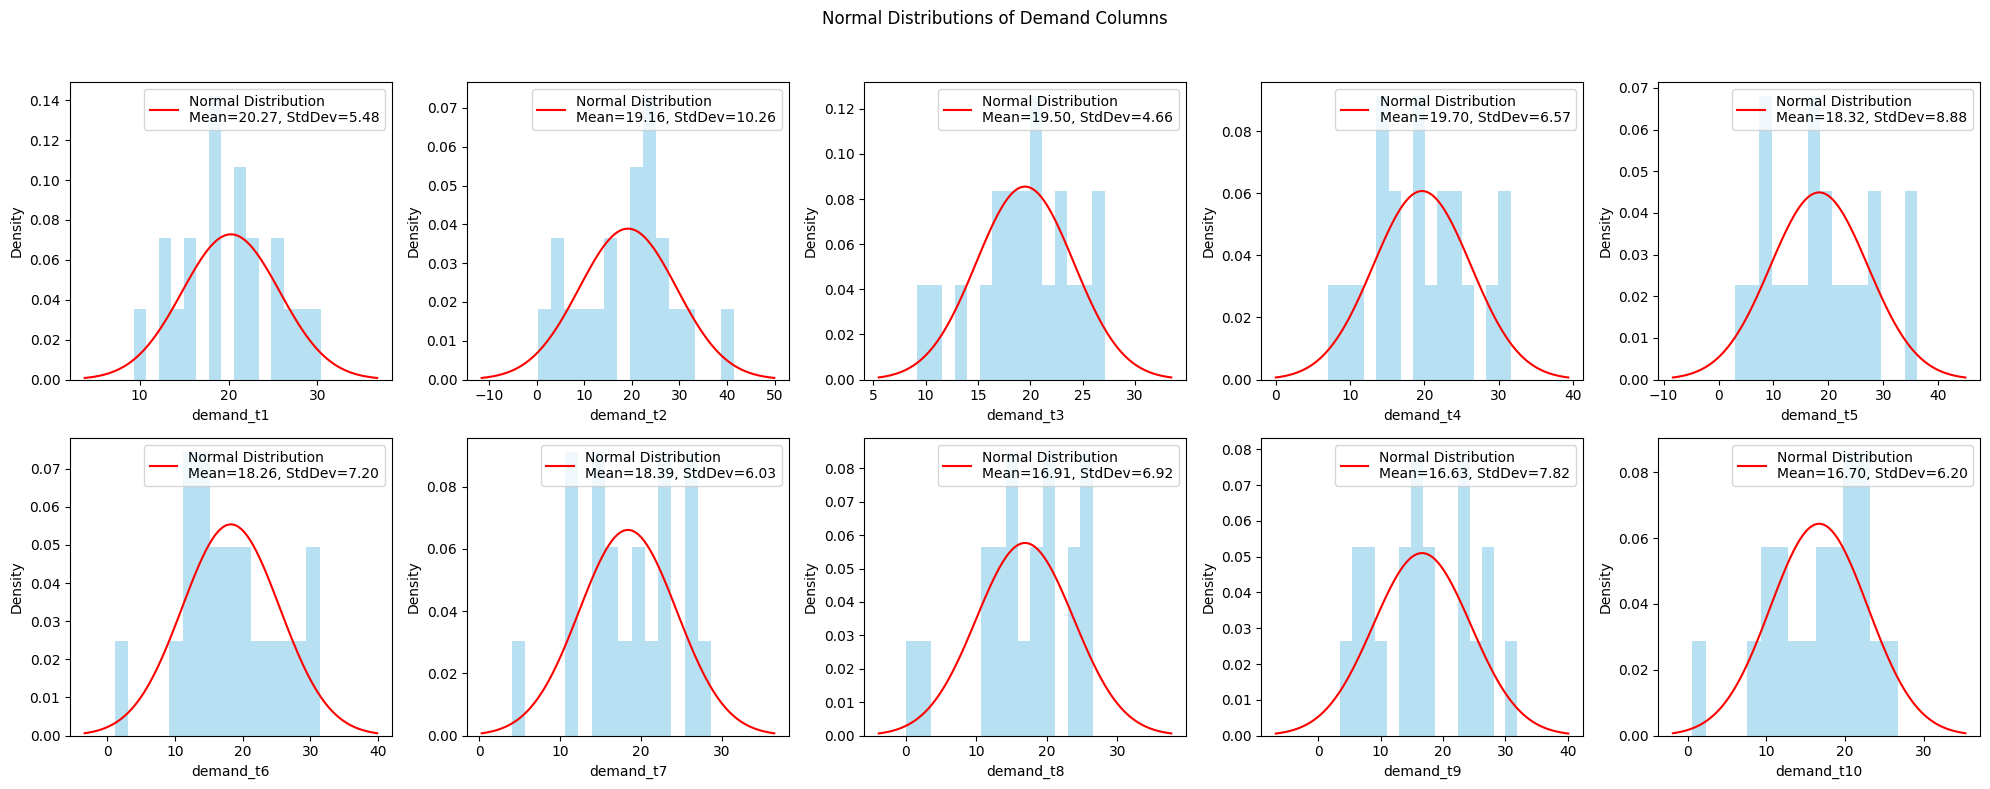

In [30]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [31]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,31.605758,9.410009,9.008299,23.418839,-4.494023,-1.921274,11.094547,-11.424254,-7.739730,-5.181547
demand_t2,9.410009,110.713541,32.737584,37.986075,-68.646732,-0.315299,-20.045194,7.990806,23.331571,-4.207789
demand_t3,9.008299,32.737584,22.884960,11.210757,-7.086806,13.042622,-0.744349,12.230793,-10.123994,-5.382893
demand_t4,23.418839,37.986075,11.210757,45.420315,-24.102303,-5.430719,2.696562,-21.426177,19.172520,-4.847938
demand_t5,-4.494023,-68.646732,-7.086806,-24.102303,82.986274,27.790421,28.631149,16.327466,-17.939418,7.334368
demand_t6,-1.921274,-0.315299,13.042622,-5.430719,27.790421,54.560109,28.134931,37.731898,-19.254955,5.196337
demand_t7,11.094547,-20.045194,-0.744349,2.696562,28.631149,28.134931,38.304137,16.845923,0.236322,21.666891
demand_t8,-11.424254,7.990806,12.230793,-21.426177,16.327466,37.731898,16.845923,50.359005,-5.822027,20.489600
demand_t9,-7.739730,23.331571,-10.123994,19.172520,-17.939418,-19.254955,0.236322,-5.822027,64.380476,30.196502
demand_t10,-5.181547,-4.207789,-5.382893,-4.847938,7.334368,5.196337,21.666891,20.489600,30.196502,40.423365


In [32]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,9.764797,8.865692,8.407627,0.921305,11.330704,4.716476,14.486148,0.394035,10.585481,4.359252
demand_t2,8.865692,45.992552,7.744691,20.208318,41.504524,5.772687,4.491348,4.393432,18.209383,1.805770
demand_t3,8.407627,7.744691,1.227533,3.062267,6.162951,20.410789,13.710653,11.910376,1.699449,1.542326
demand_t4,0.921305,20.208318,3.062267,3.841605,6.337722,2.185655,2.999150,3.821281,15.824384,14.475461
demand_t5,11.330704,41.504524,6.162951,6.337722,42.634729,12.761427,18.492608,4.741548,12.251058,11.551043
demand_t6,4.716476,5.772687,20.410789,2.185655,12.761427,13.649474,5.725970,17.046209,6.532907,0.550246
demand_t7,14.486148,4.491348,13.710653,2.999150,18.492608,5.725970,9.767970,15.556008,0.540458,5.847708
demand_t8,0.394035,4.393432,11.910376,3.821281,4.741548,17.046209,15.556008,11.720363,1.557096,15.536401
demand_t9,10.585481,18.209383,1.699449,15.824384,12.251058,6.532907,0.540458,1.557096,30.352107,17.534669
demand_t10,4.359252,1.805770,1.542326,14.475461,11.551043,0.550246,5.847708,15.536401,17.534669,3.014608


### Validate the corr matrix of damand_df is close to original setting


In [33]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.159077,0.334954,0.618098,-0.087750,-0.046267,0.318863,-0.286356,-0.171580,-0.144964
demand_t2,0.159077,1.000000,0.650386,0.535672,-0.716170,-0.004057,-0.307813,0.107017,0.276354,-0.062898
demand_t3,0.334954,0.650386,1.000000,0.347724,-0.162619,0.369107,-0.025141,0.360281,-0.263754,-0.176980
demand_t4,0.618098,0.535672,0.347724,1.000000,-0.392582,-0.109092,0.064649,-0.448003,0.354550,-0.113140
demand_t5,-0.087750,-0.716170,-0.162619,-0.392582,1.000000,0.413004,0.507824,0.252567,-0.245430,0.126632
demand_t6,-0.046267,-0.004057,0.369107,-0.109092,0.413004,1.000000,0.615440,0.719834,-0.324884,0.110648
demand_t7,0.318863,-0.307813,-0.025141,0.064649,0.507824,0.615440,1.000000,0.383560,0.004759,0.550627
demand_t8,-0.286356,0.107017,0.360281,-0.448003,0.252567,0.719834,0.383560,1.000000,-0.102249,0.454128
demand_t9,-0.171580,0.276354,-0.263754,0.354550,-0.245430,-0.324884,0.004759,-0.102249,1.000000,0.591920
demand_t10,-0.144964,-0.062898,-0.176980,-0.113140,0.126632,0.110648,0.550627,0.454128,0.591920,1.000000


In [34]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [35]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [36]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (10, 10), Test size: (10, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  18.983674  30.433868  22.754177  19.626266  15.445056  14.812940   
1  16.322423  22.452494  19.626252  23.178855  10.412501  13.037681   
2  21.401028  19.942260  22.019712  14.568653  20.305671  14.752316   
3  26.678838  14.281307  19.702800  22.965390  26.224115  28.989238   
4  25.538998  19.581920  20.202805  14.902208   8.698713  18.426185   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  14.774223  20.215903  23.568330   20.972546  
1   4.010334   3.472112   9.372295    0.588769  
2  14.939508  14.518569   6.879041    9.120182  
3  28.705340  20.867050  15.440646   19.501281  
4  20.560533  20.546294   3.481343   17.767353  

Fold 2:
Train size: (10, 10), Test size: (10, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  22.881244  21.479686  23.822757  25.394595  13.556896  15.407605   
1  18.

In [37]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [38]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [39]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 175.24908843677085
std of sum: 28.677047050944203
95.0 percentile of sum: 222.41863328877443
Q_star: 222.41863328877443

mean of sum: 186.54543840132823
std of sum: 23.56924526932134
95.0 percentile of sum: 225.31339696708025
Q_star: 225.31339696708025



## Data3: Qk hat df


### Functions


In [40]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [41]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [42]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [43]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [44]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [45]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [46]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [47]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

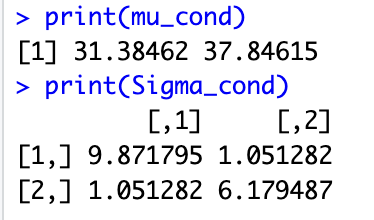
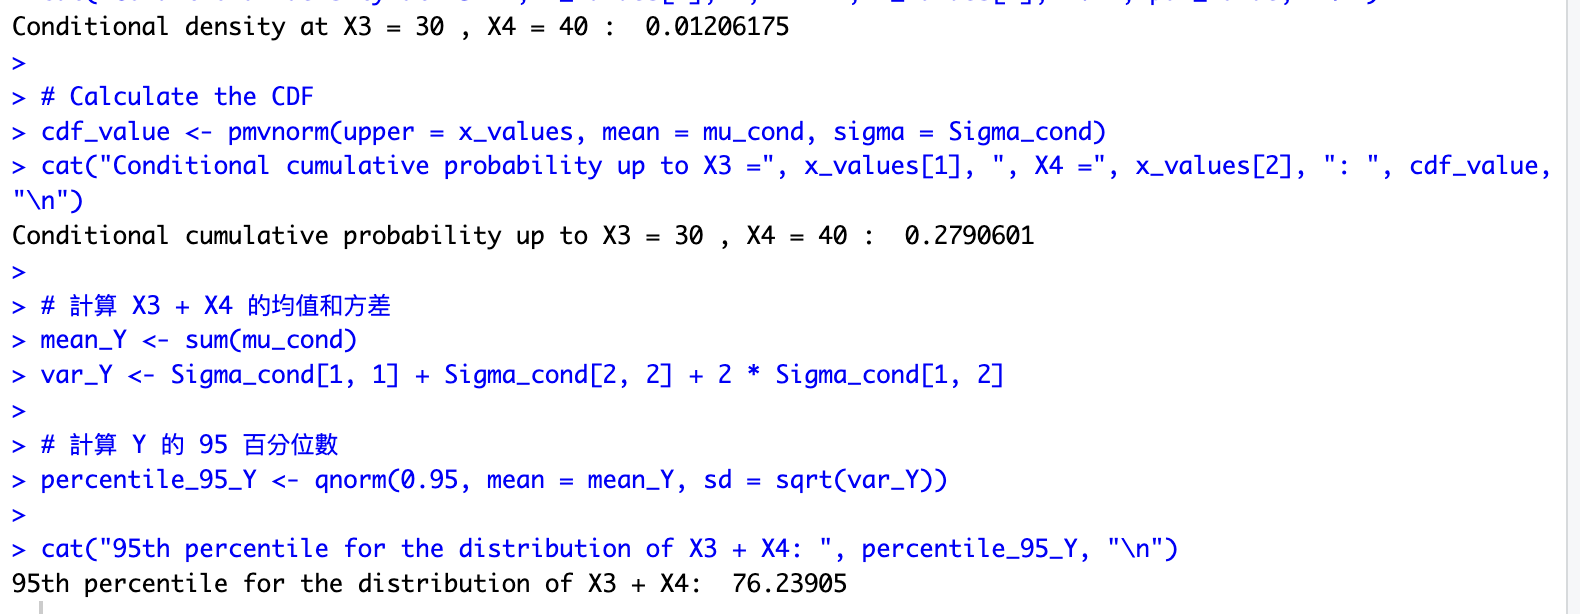


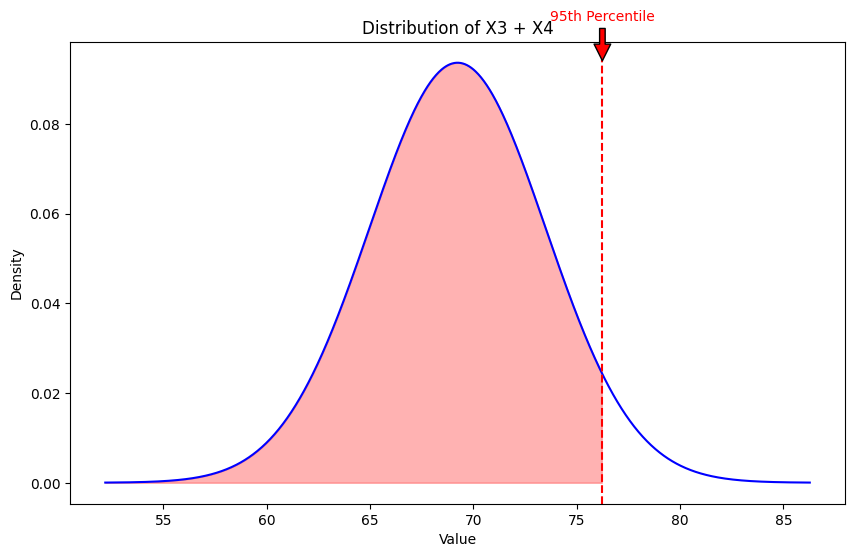

In [48]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


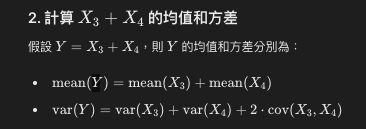


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [49]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.019062296389834
模擬計算的Y的方差: 2.9653345136351845


### Calculate Qk hat for 2~T-1 of demand_df_train


In [50]:
demand_df_train = demand_folds[0][0]

In [51]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [52]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [53]:
Qk_hat_df

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,229.955762,212.815551,215.476183,221.156222,231.896360,240.681748,212.527636,200.847408
1,230.133088,233.142923,241.376869,242.845644,241.156486,246.315688,235.479160,229.775893
2,242.295333,260.312294,258.398886,259.686709,243.310034,244.020431,226.925408,214.534333
3,213.607295,218.445022,219.999281,222.524315,212.481851,202.464199,199.344651,205.660050
4,235.166596,220.289707,197.717789,200.711326,164.840641,150.168001,128.351913,125.785902
5,230.045148,238.822306,237.316131,233.444814,237.264177,218.917027,211.192171,204.566888
6,224.735572,229.580224,209.602850,201.585801,197.357250,191.323414,171.404648,171.089580
7,243.138330,232.611848,230.826142,230.621959,234.419329,245.802953,230.220081,224.600369
8,230.225645,241.850586,222.996627,226.422483,235.584293,243.998650,242.187141,226.520691
9,234.158233,231.201300,234.103140,226.384722,220.385120,201.724955,187.745660,165.254392


### Plot the distribuction


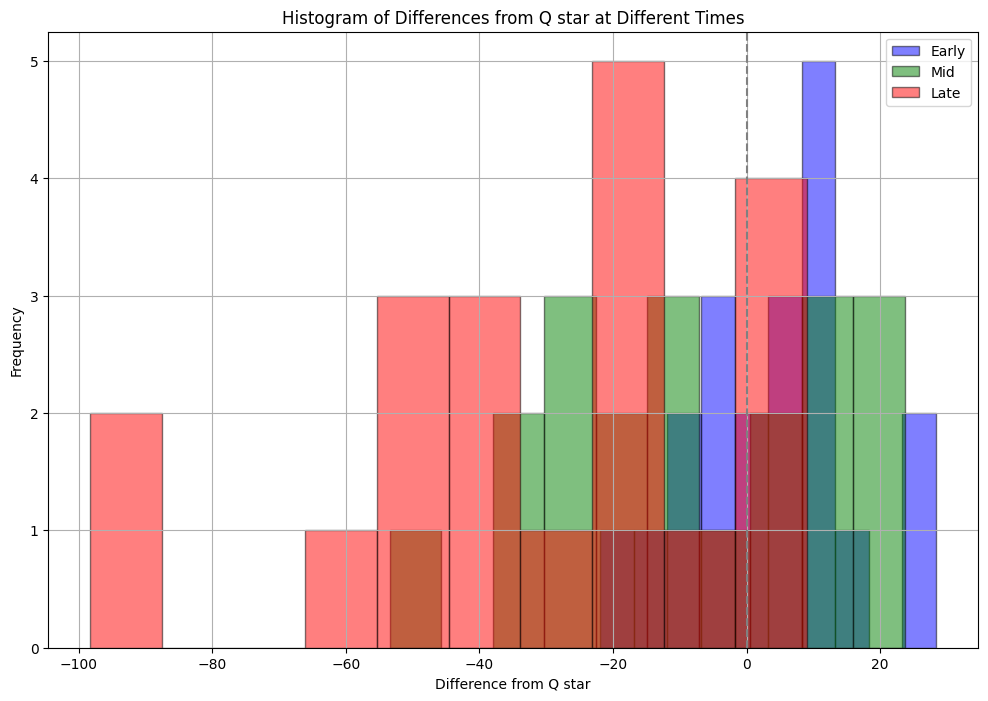

Q_star is: 225.31339696708025
Early bias: 3.8069861593013017
Mid bias: -8.268557160379794
Late bias: -32.207371597287036


In [54]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

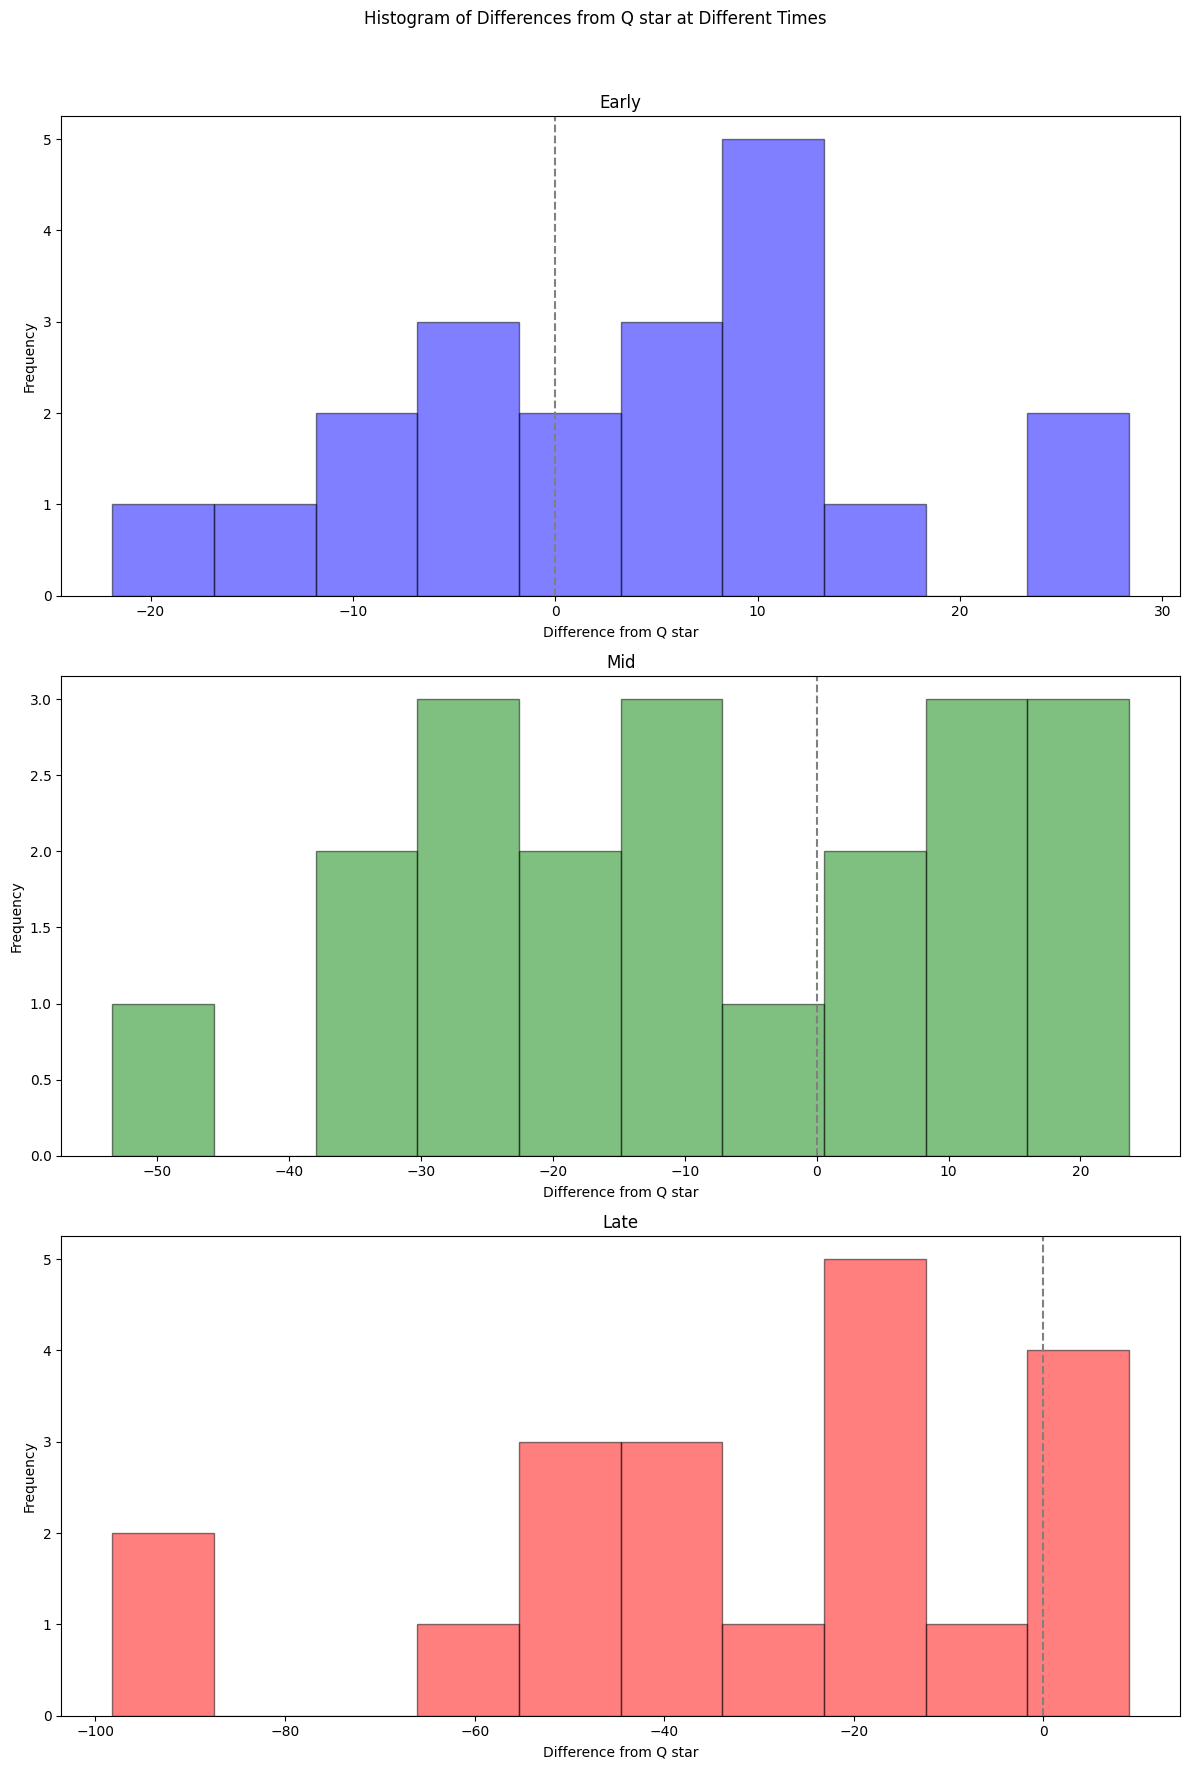

In [55]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## S0 - One-time Procurement


In [151]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [152]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [153]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [154]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [155]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [ ]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )
            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Sold_0_lb_{i}")
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub_{i}")
            model.addConstr(Sold_0s[i] >= total_demand_up_to_k_minus_1_vars[i] + Q0_vars[i] - M * (1 - Sold_0_binary), name=f"Sold_0_aux1_{i}")
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(Left_0s[i] <= Q0_vars[i], name=f"Left_0_ub_{i}")
            model.addConstr(Left_0s[i] <= Q0_vars[i] - Sold_0s[i], name=f"Left_0_diff_{i}")
            model.addConstr(Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}")
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_lb2_{i}")
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_nonneg_{i}")

            # Lost_0 的線性化
            model.addConstr(Lost_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Lost_0_ub_{i}")
            model.addConstr(Lost_0s[i] <= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"Lost_0_diff_{i}")
            model.addConstr(Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"Lost_0_lb1_{i}")
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_lb2_{i}")
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_nonneg_{i}")

            # Q1 + Left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_lb_{i}")
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub_{i}")
            model.addConstr(Sold_1s[i] >= total_demand_from_k_to_T_vars[i] + Q1_plus_lefts[i] - M * (1 - Sold_1_binary), name=f"Sold_1_aux1_{i}")
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(Left_1s[i] <= Q1_plus_lefts[i], name=f"Left_1_ub_{i}")
            model.addConstr(Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_diff_{i}")
            model.addConstr(Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}")
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_lb2_{i}")
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_nonneg_{i}")

            # Lost_1 的線性化
            model.addConstr(Lost_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Lost_1_ub_{i}")
            model.addConstr(Lost_1s[i] <= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"Lost_1_diff_{i}")
            model.addConstr(Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"Lost_1_lb1_{i}")
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_lb2_{i}")
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_nonneg_{i}")
            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Qk_hat.append(Q_hats[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (assigned_R+1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(assigned_R+1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [157]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)  # 紀錄該策略組合每一次模擬的 Q0
            results_dict["Q1_vars"].append(Q1_vars)  # 紀錄該策略組合每一次模擬的 Q1

            print(f"The average profits is {average_profits}")

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [158]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [159]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [160]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [161]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [162]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )
        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [163]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [164]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [165]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [166]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [167]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [168]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [169]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [170]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [171]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [172]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [173]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [174]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [175]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [176]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411261441

In [177]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [178]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [179]:
training_df.shape

(10, 2)

In [180]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 175.24908843677085
std of sum: 28.677047050944203
50.0 percentile of sum: 175.24908843677085
Q_star: 175.24908843677085


In [181]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,175.870930,179.490340,179.427115,180.955252,209.639725,203.699012,195.220455,199.604133
1,172.089380,173.370425,171.403030,179.412711,130.503939,125.357269,122.590615,121.973715
2,179.305914,180.273904,182.668914,182.328929,179.288671,154.948456,160.144606,161.041901
3,186.805510,186.626591,187.451703,196.226398,197.876850,211.105246,219.096858,220.959098
4,185.185835,186.352293,186.126330,173.651638,159.657994,175.328048,171.663500,172.013472
5,168.816679,164.774592,166.457132,160.235884,148.646034,147.632270,145.233923,152.180145
6,162.143097,163.285335,161.684287,162.377977,176.817182,187.128540,194.196193,198.404981
7,175.796282,172.742351,173.233653,184.040473,200.378437,205.258522,198.246200,194.219765
8,166.855070,168.191845,170.298354,165.709941,166.189428,171.124685,172.474112,162.293632
9,179.622187,177.383210,173.740366,167.551682,183.492624,170.908835,173.624421,169.800043


## Training


### S0 - One-time procurement strategy


In [182]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/10 with initial inventory Q_star=175.24908843677085
--------------------------------------------------
Day 1
Demand      : 18.983673586286056
Sales       : 18.983673586286056
Loss        : 0
Left        : 156.2654148504848
Inventory   : 156.2654148504848
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 30.43386763296133
Sales       : 30.43386763296133
Loss        : 0
Left        : 125.83154721752348
Inventory   : 125.83154721752348
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 22.75417675011091
Sales       : 22.75417675011091
Loss        : 0
Left        : 103.07737046741256
Inventory   : 103.07737046741256
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 19.62626640176582
Sales       : 19.62626640176582
Loss        : 0
Left        : 83.45110406564675


In [183]:
baseline_stimulation_df

,losses,lefts,operation_profits,profits
0,26.337894,0.000000,87624.544218,74455.597418
1,0.000000,52.775372,61236.858326,34849.172434
2,0.000000,16.802149,79223.469620,70822.395022
3,48.106917,0.000000,87624.544218,63571.085620
4,0.000000,5.542737,84853.175660,82081.807102
5,0.000000,21.233832,77007.628022,66390.711825
6,20.900454,0.000000,87624.544218,77174.317087
7,16.323972,0.000000,87624.544218,79462.558172
8,0.000000,11.097745,82075.671901,76526.799583
9,0.000000,4.217402,85515.843205,83407.142191


### S1 - Grid for Fixed F & Fixed Rk


In [184]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 175.24908843677085
期初庫存 Q0: 17.524908843677085
重新估計量 Qk_hat: 175.87093048479875
訂貨量 Q1 為 158.34602164112167

第一階段：期初庫存 Q0: 17.524908843677085，需求量為 18.983673586286056，Sold_0 為 17.524908843677085，Left_0 為 0.0，Lost_0 為 1.4587647426089703
第二階段：期初庫存 Q1+left_0 為 158.34602164112167，需求量為 182.60330845158398，Sold_1 為 158.34602164112167，Left_1 為 0.0，Lost_1 為 24.25728681046232

統計結果：Sold 為 175.87093048479875, Lost 為 25.71605155307129 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 12858.025776535644，Profit 為 75077.43946586372
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 175.24908843677085
期初庫存 Q0: 17.524908843677085
重新估計量 Qk_hat: 172.0893796836034
訂貨量 Q1 為 154.56447083992632

第一階段：期初庫存 Q0: 17.524908843677085，需求量為 16.322423343851618，Sold_0 為 16.322423343851618，Left_0 為 1.2024854998254675，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 155.76695633975177，需求量為 106.15129330878364，Sold_1 為 106.15129330878364，Left_1 為 49.615663030968136，Lost_1 為 0

統計結果

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
62,8,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[37.49627560136034, 0, 2.420426656327521, 61.3...",82521.944270,1.814273,6.576655,86717.407915
52,7,0.8,"[140.19927074941668, 140.19927074941668, 140.1...","[63.49974164437762, 0, 14.749185200119626, 70....",82191.031780,3.127608,4.611808,86060.740093
53,7,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[45.97483280070054, 0, 0, 53.381065967590644, ...",82045.211099,2.211737,6.735192,86518.675563
51,7,0.7,"[122.6743619057396, 122.6743619057396, 122.674...","[81.0246504880547, 2.6829075897445307, 32.2740...",81400.964576,4.149053,4.149053,85550.017671
42,6,0.7,"[122.6743619057396, 122.6743619057396, 122.674...","[86.96536356237078, 7.829576899723577, 56.6143...",78590.179784,6.022910,6.022910,84613.089407
...,...,...,...,...,...,...,...,...
55,8,0.2,"[35.04981768735417, 35.04981768735417, 35.0498...","[160.17063750709994, 87.5407973041255, 125.094...",-54507.409255,94.754636,94.754636,40247.226394
65,9,0.3,"[52.57472653103126, 52.57472653103126, 52.5747...","[147.02940690000702, 69.39898847739705, 108.46...",-55583.948003,95.472328,95.472328,39888.380145
54,8,0.1,"[17.524908843677085, 17.524908843677085, 17.52...","[177.69554635077702, 105.06570614780259, 142.6...",-80794.772521,112.279544,112.279544,31484.771972
64,9,0.2,"[35.04981768735417, 35.04981768735417, 35.0498...","[164.55431574368413, 86.92389732107415, 125.99...",-81871.311268,112.997237,112.997237,31125.925723


In [185]:
stimulation_results_df_1

,R(T),F,profits,losses,lefts,Left0s,Left1s,operation_profits,Q0,Q1
0,8,0.9,94426.964176,6.366527,0.000000,20.893976,0.000000,97610.227597,157.72418,37.496276
1,8,0.9,43611.626856,0.000000,35.250463,48.683639,35.250463,61236.858326,157.72418,0.000000
2,8,0.9,78374.636116,0.000000,1.697667,29.795032,1.697667,79223.469620,157.72418,2.420427
3,8,0.9,99073.301849,9.822850,5.563702,0.000000,5.563702,106766.577937,157.72418,61.372679
4,8,0.9,83874.601424,0.000000,1.957148,29.812818,1.957148,84853.175660,157.72418,13.939320
5,8,0.9,75153.166247,0.000000,3.708924,45.032110,3.708924,77007.628022,157.72418,0.000000
6,8,0.9,96121.421887,1.953349,0.000000,38.189246,0.000000,97098.096618,157.72418,36.472014
7,8,0.9,92449.960399,0.000000,6.673140,3.257697,6.673140,95786.530265,157.72418,40.522021
8,8,0.9,77914.287864,0.000000,8.322768,40.954756,8.322768,82075.671901,157.72418,14.749932
9,8,0.9,84219.475882,0.000000,2.592735,32.400838,2.592735,85515.843205,157.72418,15.900241


In [186]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 175.24908843677085
Maximum Profit: 82521.94427004398


In [187]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

,R(T),F,average_profits
62,8,0.9,82521.944270
52,7,0.8,82191.031780
53,7,0.9,82045.211099


Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_med_with_holding_cost_20_20_202411261441.png


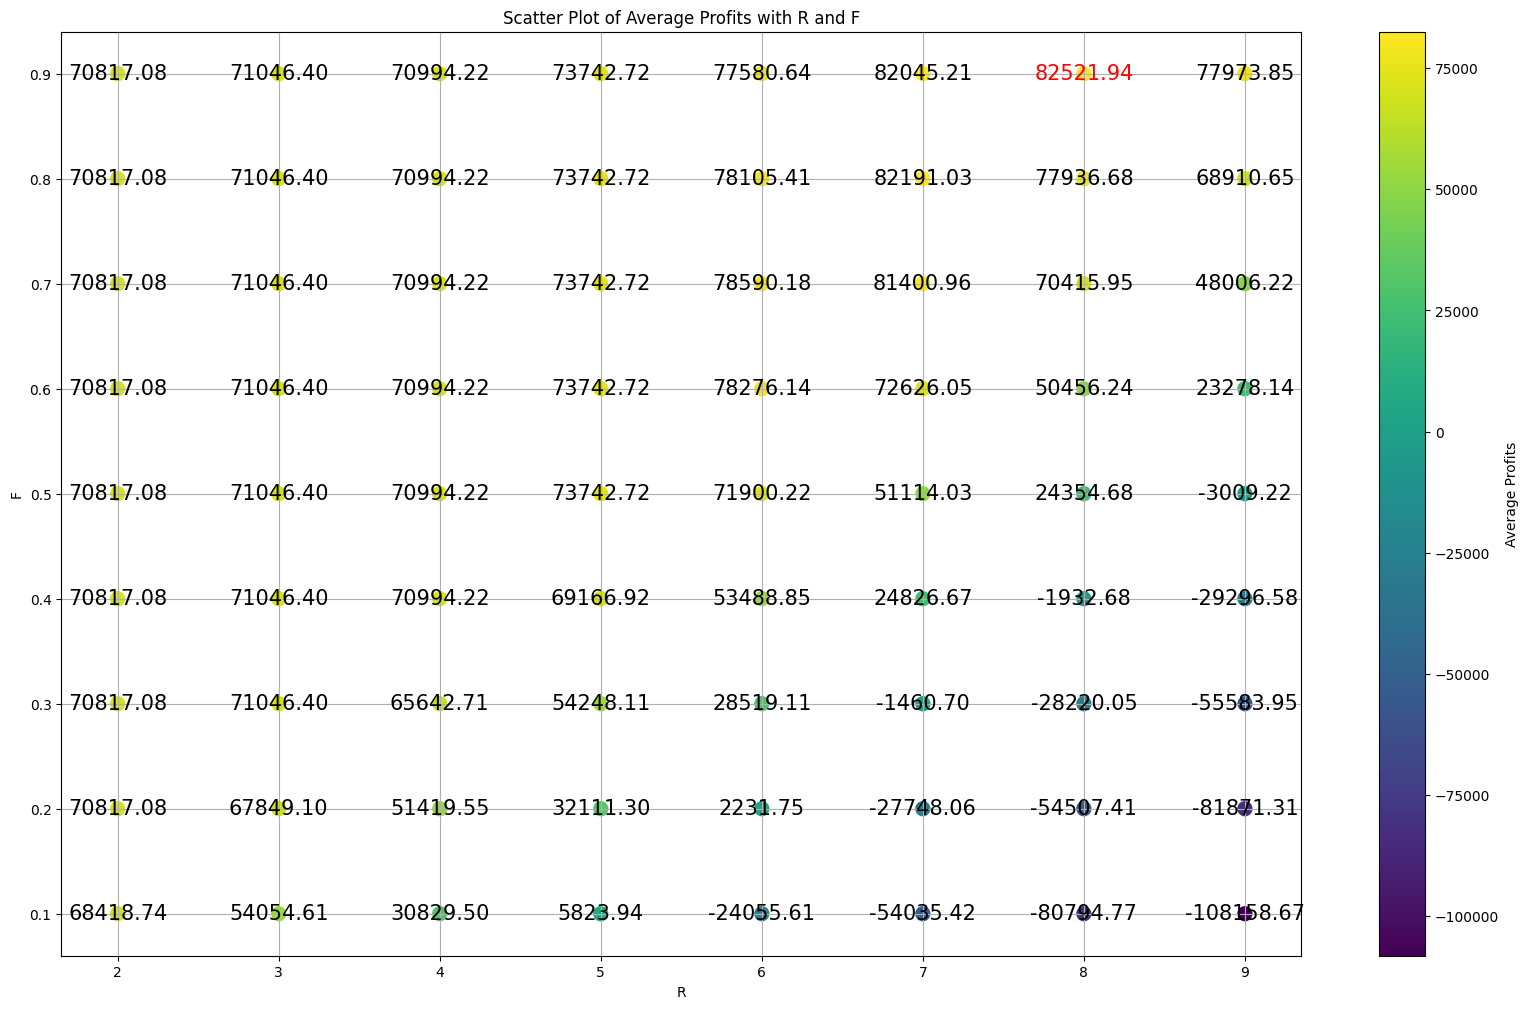

In [188]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_med_with_holding_cost_20_20_202411261441.png


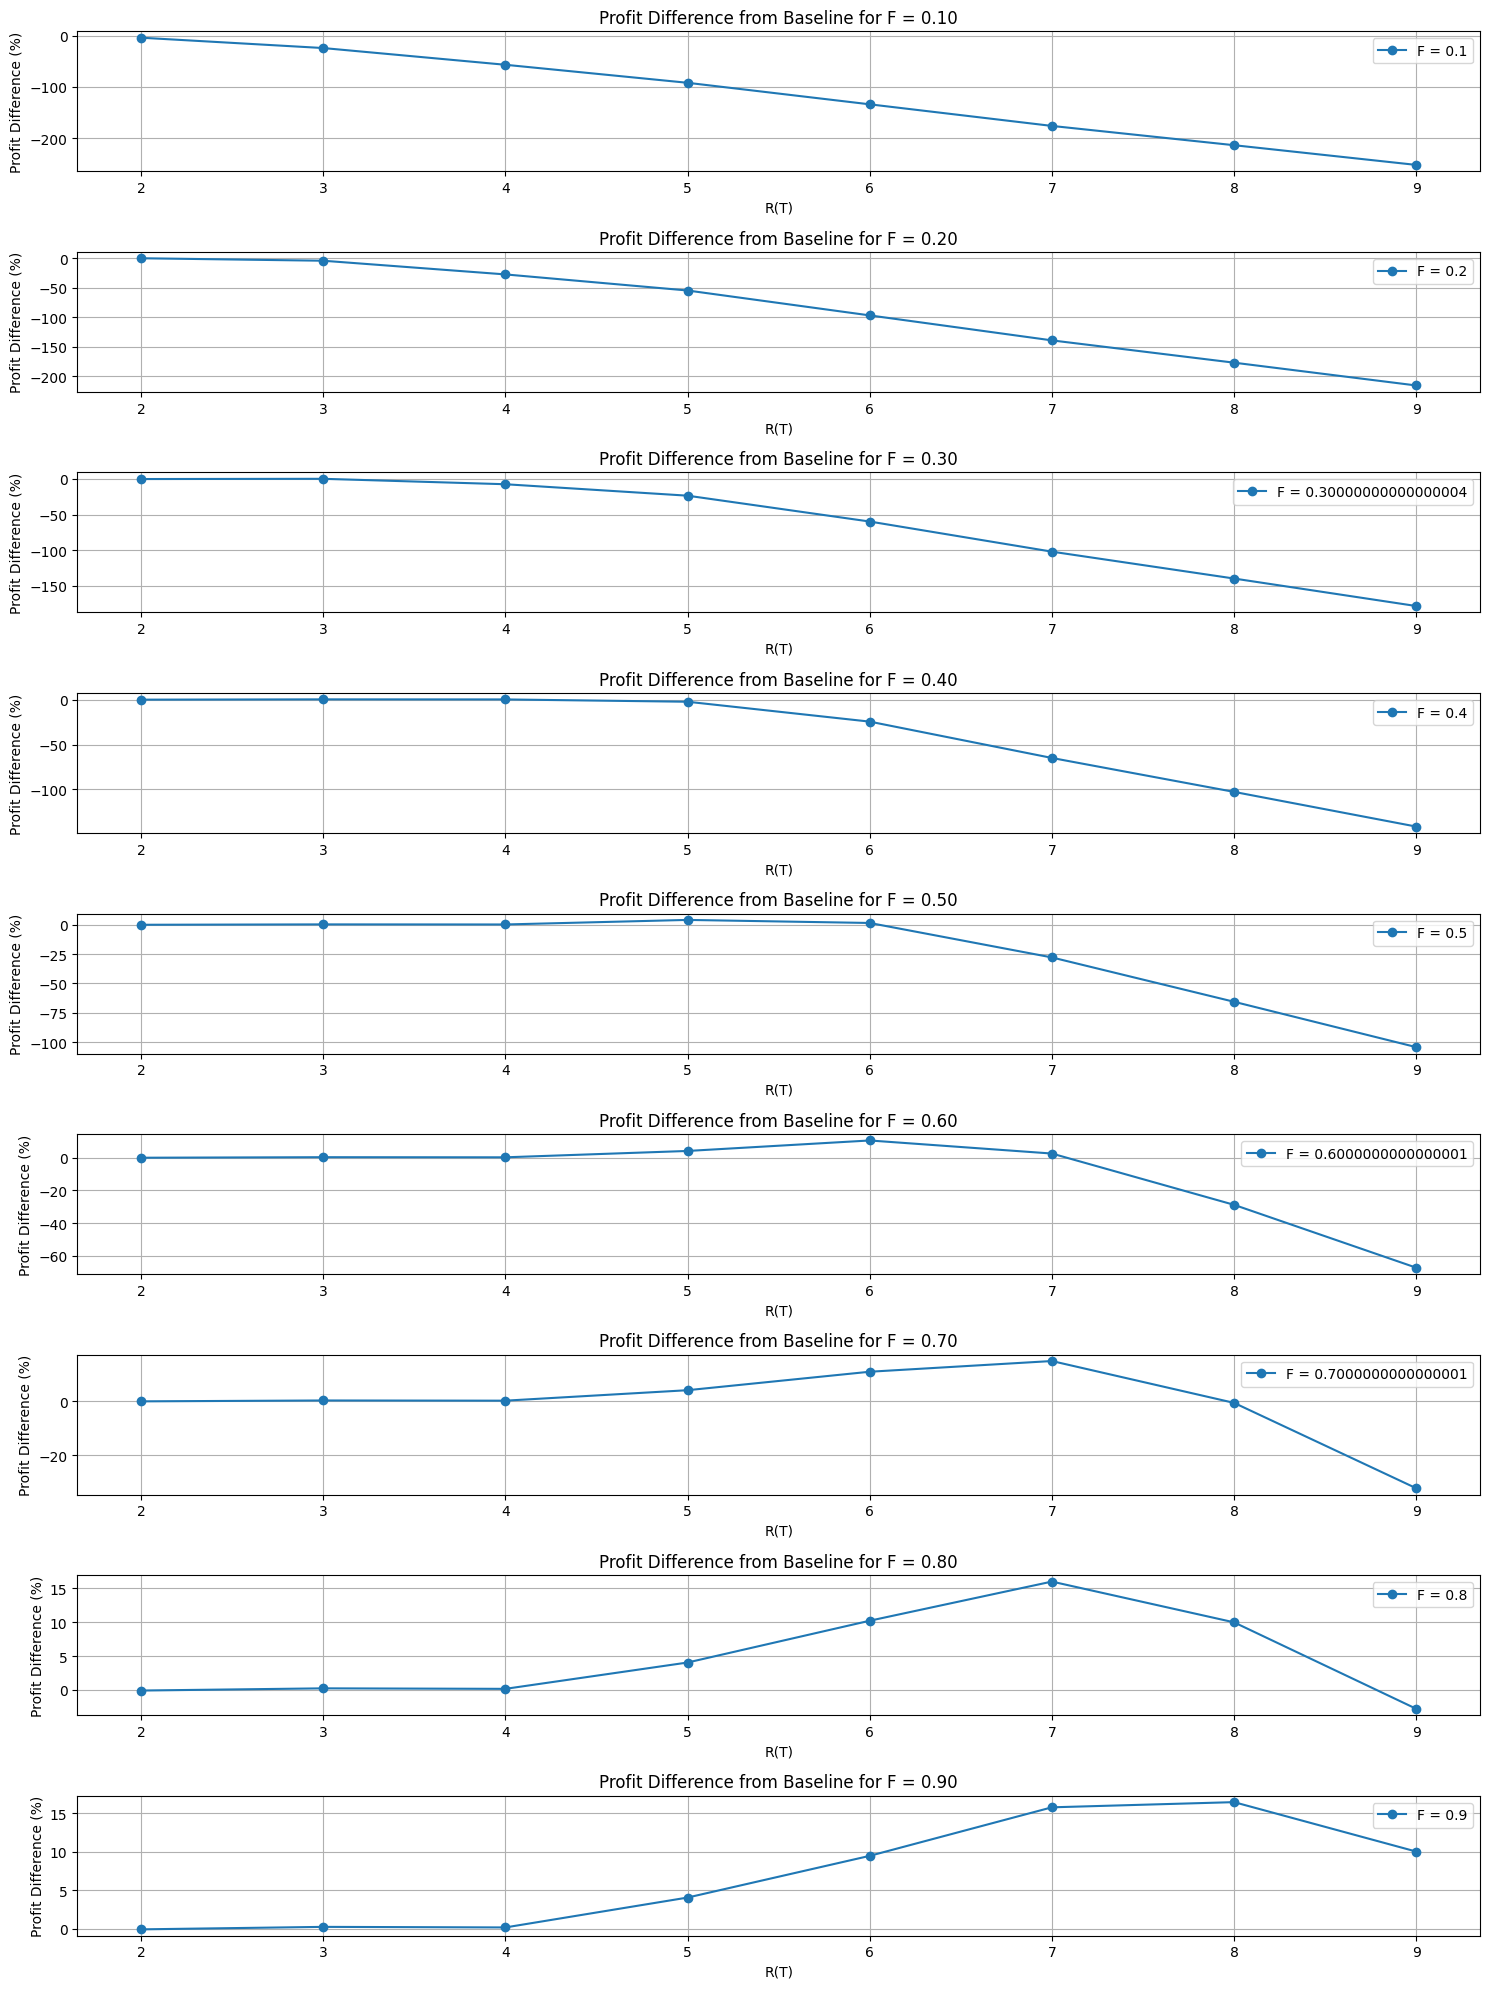

In [189]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [190]:
results_df_8, stimulation_results_df_8 = None, None

results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
    holding_cost=holding_cost,
)
results_df_8





max_profit is changed from None to 52863.84099249342




max_profit is changed from 52863.84099249342 to 55466.90919716181








































max_profit is changed from 55466.90919716181 to 56657.28853393942








































max_profit is changed from 56657.28853393942 to 57419.89483859163








































max_profit is changed from 57419.89483859163 to 60450.30964227436








































max_profit is changed from 60450.30964227436 to 65213.84229176967








































max_profit is changed from 65213.84229176967 to 68018.2662121865


















































































,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
51,7,0.7,"[122.6743619057396, 122.6743619057396, 122.674...","[81.0246504880547, 2.6829075897445307, 32.2740...",68018.266212,4.149053,4.149053,85550.017671
52,7,0.8,"[140.19927074941668, 140.19927074941668, 140.1...","[63.49974164437762, 0, 14.749185200119626, 70....",67811.565092,3.127608,4.611808,86060.740093
62,8,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[37.49627560136034, 0, 2.420426656327521, 61.3...",66742.681411,1.814273,6.576655,86717.407915
53,7,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[45.97483280070054, 0, 0, 53.381065967590644, ...",66277.015508,2.211737,6.735192,86518.675563
41,6,0.6,"[105.14945306206252, 105.14945306206252, 105.1...","[104.49027240604786, 25.35448574340066, 74.139...",65213.842292,6.232268,6.232268,84508.410031
...,...,...,...,...,...,...,...,...
65,9,0.3,"[52.57472653103126, 52.57472653103126, 52.5747...","[147.02940690000702, 69.39898847739705, 108.46...",-71785.341978,95.472328,95.472328,39888.380145
45,7,0.1,"[17.524908843677085, 17.524908843677085, 17.52...","[186.17410355011722, 107.83236065180705, 137.4...",-72115.292189,94.439978,94.439978,40404.555423
64,9,0.2,"[35.04981768735417, 35.04981768735417, 35.0498...","[164.55431574368413, 86.92389732107415, 125.99...",-98423.203421,112.997237,112.997237,31125.925723
54,8,0.1,"[17.524908843677085, 17.524908843677085, 17.52...","[177.69554635077702, 105.06570614780259, 142.6...",-98462.283193,112.279544,112.279544,31484.771972


In [191]:
stimulation_results_df_8

,R(T),F,profits,losses,lefts,operation_profits,Q0,Q1,hc0,hc1,Left0s,Left1s,lost0s,lost1s
0,7,0.7,84965.780391,0.000000,2.112030,100793.491019,122.674362,81.024650,612.952180,125.632593,0.618381,2.112030,0.000000,0.000000
1,7,0.7,50518.677936,0.000000,2.883553,61236.858326,122.674362,2.682908,429.004275,34.815924,17.644155,2.883553,0.000000,0.000000
2,7,0.7,64588.231152,3.498483,0.000000,77474.227975,122.674362,32.274094,493.899534,62.938224,9.684722,0.000000,0.000000,3.498483
3,7,0.7,78115.654007,16.167327,3.916567,103594.339286,122.674362,88.430884,633.315737,138.521176,0.000000,3.916567,16.167327,0.000000
4,7,0.7,68395.264875,0.000000,5.621697,84853.175660,122.674362,52.653686,571.954744,110.398374,15.323533,5.621697,0.000000,0.000000
5,7,0.7,58516.754387,6.382986,0.000000,73816.135149,122.674362,24.957908,526.270625,79.123770,27.791271,0.000000,0.000000,6.382986
6,7,0.7,74302.667781,9.021002,0.000000,93564.270125,122.674362,64.454178,614.377733,123.177323,17.664037,0.000000,0.000000,9.021002
7,7,0.7,64104.441099,6.297881,19.983343,92637.589538,122.674362,82.584160,615.775565,153.851254,0.000000,19.983343,6.297881,0.000000
8,7,0.7,65067.921379,0.000000,6.973341,82075.671901,122.674362,48.450323,566.403684,109.650311,17.676543,6.973341,0.000000,0.000000
9,7,0.7,71607.269114,0.122851,0.000000,85454.417731,122.674362,48.234474,582.198467,107.087690,23.157320,0.000000,0.000000,0.122851


In [192]:
# 比較結果
max_profit = results_df_8["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 175.24908843677085
Maximum Profit: 68018.2662121865


In [193]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_8.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

,R(T),F,average_profits
51,7,0.7,68018.266212
52,7,0.8,67811.565092
62,8,0.9,66742.681411


Plot saved as plots/grid_fixed_F_fixed_R_metrics_s8_train_med_with_holding_cost_20_20_202411261441.png


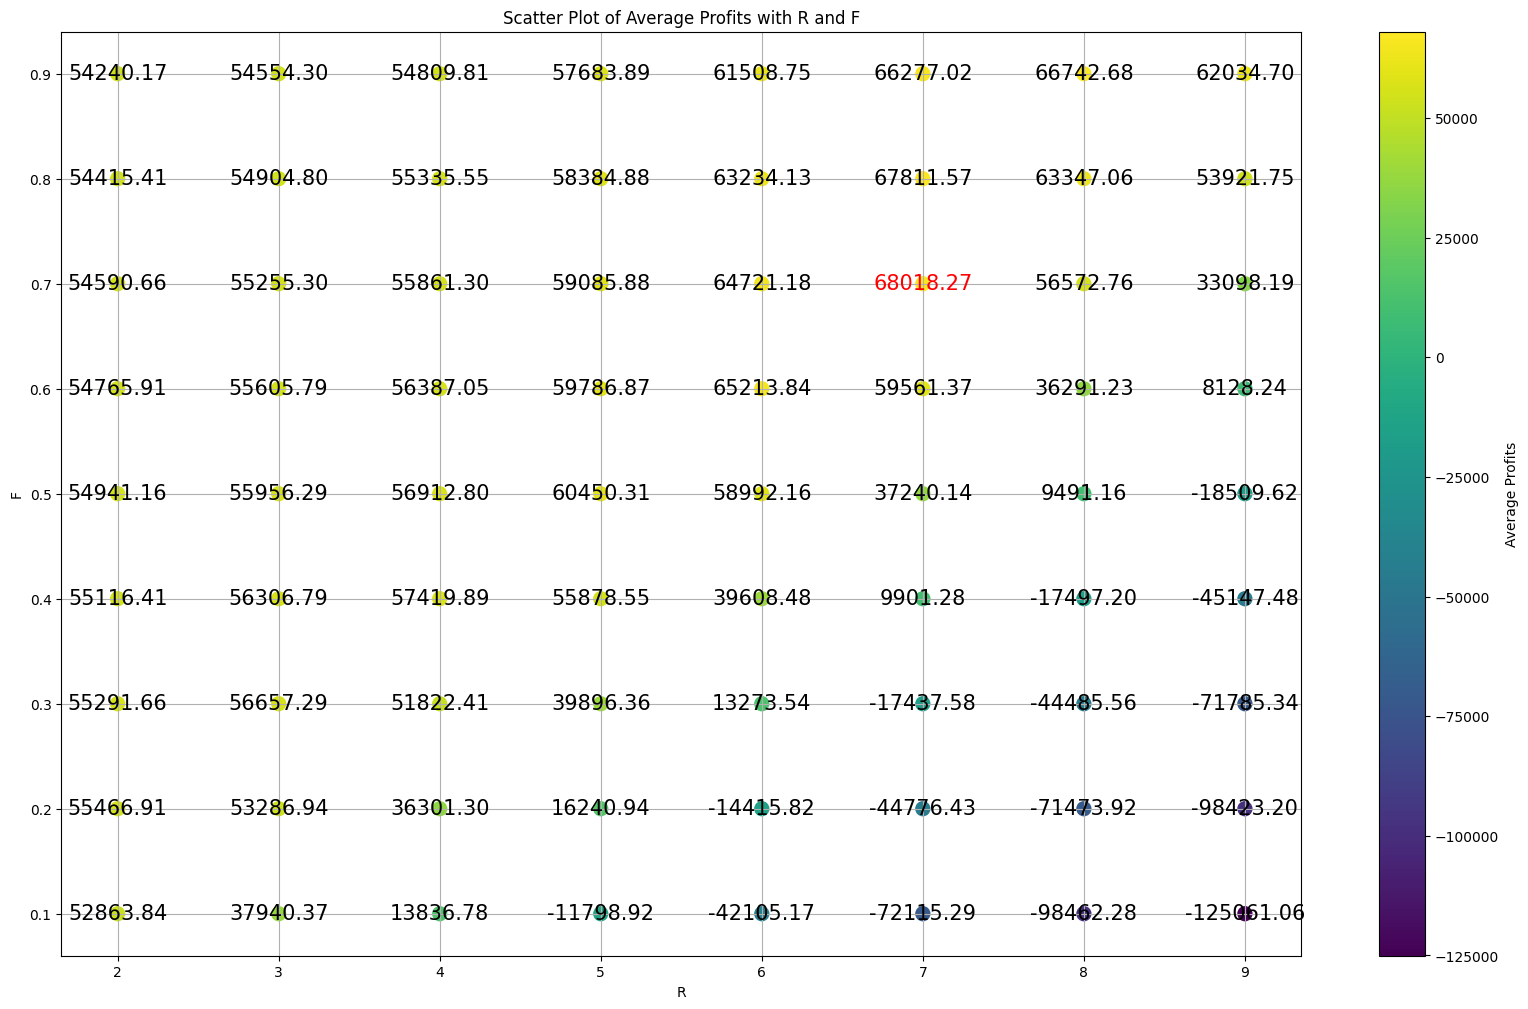

In [194]:
# 找到 'average_profits' 的最大值
max_profit = results_df_8["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_8["R(T)"],
    results_df_8["F"],
    c=results_df_8["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_8)):
    avg_profit = results_df_8["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_s8_train_med_with_holding_cost_20_20_202411261441.png


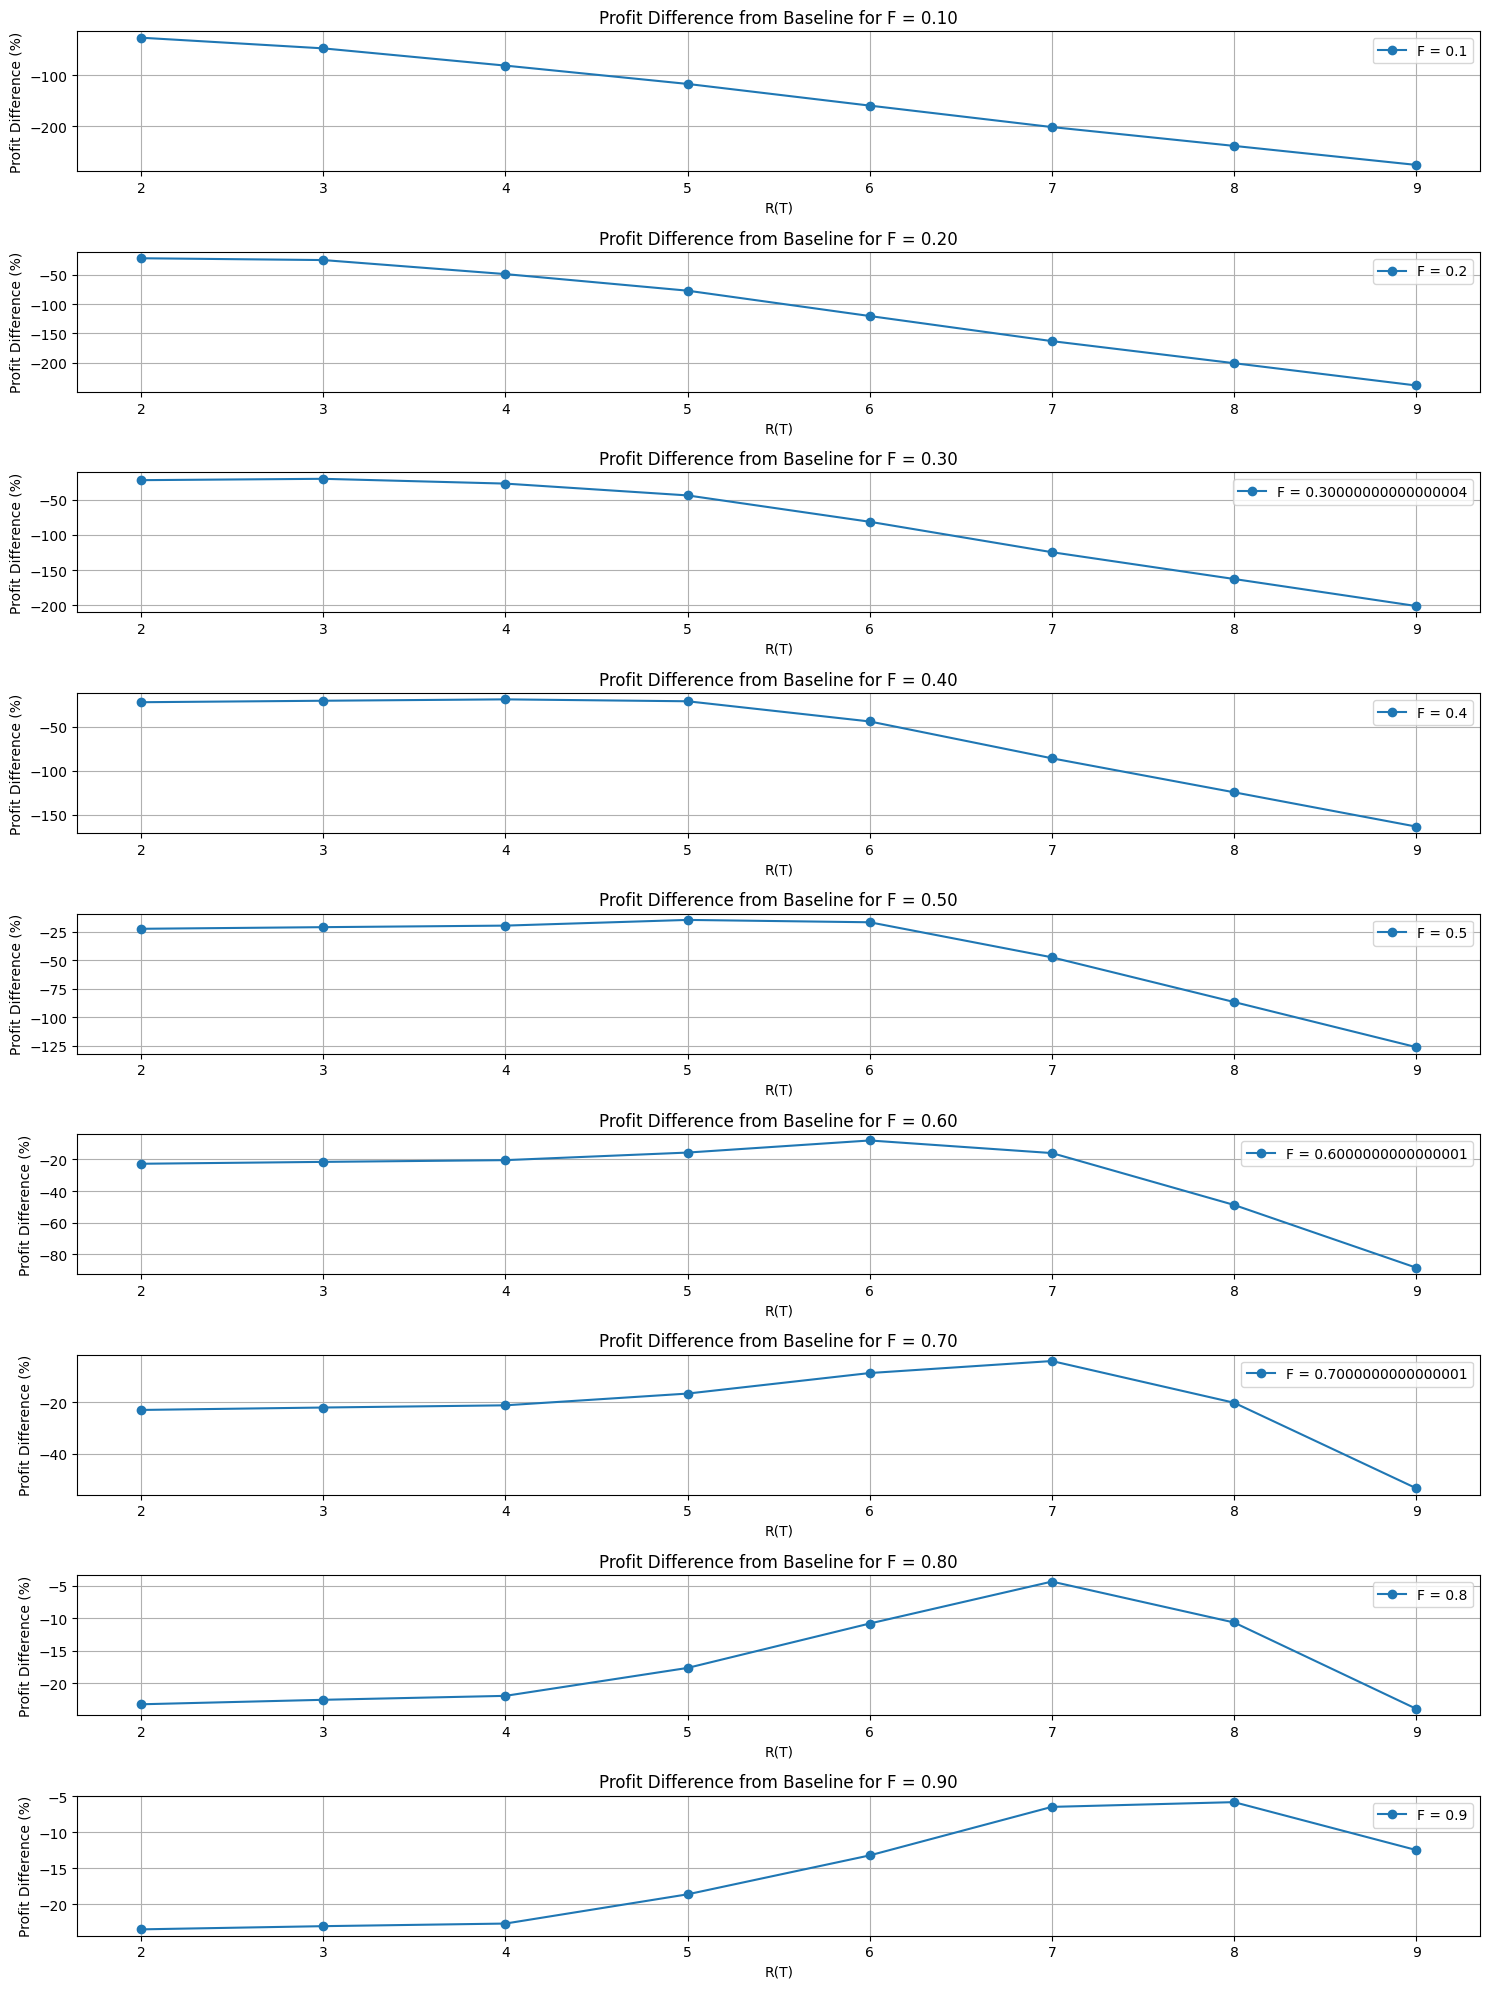

In [195]:
results_df_8["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_8["profit_diff_percent"] = (
    (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [196]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 200 rows, 343 columns and 820 nonzeros
Model fingerprint: 0xa62d4ee5
Model has 80 general constraints
Variable types: 263 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 100 rows and 140 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/1322598253.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



IIS computed: 7 constraints, 2 bounds
IIS runtime: 0.03 seconds (0.02 work units)
導致不可行的約束： Ensure_only_one_R_true_0
導致不可行的約束： Define_Q_hat_0
導致不可行的約束： Adjust_Q_hat_0
導致不可行的約束： Constr_Total_Demand_Up_to_K_Minus_1_0
導致不可行的約束： Calculate_Total_Demand_Up_to_K_minus_1_0
導致不可行的約束： Constr_Lost_0_diff_aux_0
導致不可行的變量： Q1_var[0], IIS下界： 0, IIS上界： 1
導致不可行的變量： Lost_0_aux_0, IIS下界： 1, IIS上界： 0
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is T=5 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 200 rows, 343 columns and 820 nonzeros
Model fingerprint: 0x32a41d2f
Model has 80 general constrai

,R(T),R,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,F_vars,Q0_vars,Q1_vars


In [202]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
        :, stimulation_results_df_2.iloc[0, 0]
    ]
    stimulation_results_df_2["Qk_hat-Q0"] = (
        stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
    )
    stimulation_results_df_2["Q_star"] = Q_star
    stimulation_results_df_2[["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]]

In [204]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    # Plotting the distribution of "Qk_hat-Q0"
    plt.figure(figsize=(8, 5))
    plt.hist(
        stimulation_results_df_2["Qk_hat-Q0"], bins=20, alpha=0.7, edgecolor="black"
    )
    plt.title("Distribution of Qk_hat-Q0")
    plt.xlabel("Qk_hat-Q0")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plotting the distribution of "Q1"
    plt.figure(figsize=(8, 5))
    plt.hist(stimulation_results_df_2["Q1"], bins=20, alpha=0.7, edgecolor="black")
    plt.title("Distribution of Q1")
    plt.xlabel("Q1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [205]:
Qk_hat_df_train

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,175.870930,179.490340,179.427115,180.955252,209.639725,203.699012,195.220455,199.604133
1,172.089380,173.370425,171.403030,179.412711,130.503939,125.357269,122.590615,121.973715
2,179.305914,180.273904,182.668914,182.328929,179.288671,154.948456,160.144606,161.041901
3,186.805510,186.626591,187.451703,196.226398,197.876850,211.105246,219.096858,220.959098
4,185.185835,186.352293,186.126330,173.651638,159.657994,175.328048,171.663500,172.013472
5,168.816679,164.774592,166.457132,160.235884,148.646034,147.632270,145.233923,152.180145
6,162.143097,163.285335,161.684287,162.377977,176.817182,187.128540,194.196193,198.404981
7,175.796282,172.742351,173.233653,184.040473,200.378437,205.258522,198.246200,194.219765
8,166.855070,168.191845,170.298354,165.709941,166.189428,171.124685,172.474112,162.293632
9,179.622187,177.383210,173.740366,167.551682,183.492624,170.908835,173.624421,169.800043


In [206]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

In [207]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

,R(T),average_profits


### S3 - Grid for Fixed F & Flexible Rk


In [208]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
    assigned_Fs=ASSIGNED_FS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)


results_df_3

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 694 columns and 1520 nonzeros
Model fingerprint: 0x137d5c4d
Model has 100 quadratic constraints
Model has 240 general constraints
Variable types: 604 continuous, 90 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 320 rows and 1260

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/3920300863.py:246: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        6         6         6         1         1         1           1s

IIS computed: 6 constraints, 1 bounds
IIS runtime: 0.70 seconds (0.65 work units)
導致不可行的約束： R42
導致不可行的約束： Q0_upper_bound_1
導致不可行的約束： Ensure_only_one_R_true_1
導致不可行的約束： Define_Q_hat_1
導致不可行的約束： Adjust_Q_hat_1
導致不可行的變量： Q1_var[1], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is F=0.2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 694 columns and 1520 nonzeros
Model fingerprint: 0xe3832332
Model has 100 quadratic constraints
Model has 240 general constraints
Variable types: 604

,R(T),average_losses,average_lefts,average_operation_profits,average_profits,beta_values,F_vars,Q0_vars,Q1_vars,tau_values


In [209]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [210]:
stimulation_results_df_3

""


In [211]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [212]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 715 columns and 1390 nonzeros
Model fingerprint: 0x3c51257b
Model has 100 quadratic constraints
Model has 250 general constraints
Variable types: 625 continuous, 90 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 235 rows and 12563 columns
Presolve time: 0.02s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.02 work units

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/3528171567.py:258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        7         7         7         2         2         2           1s

IIS computed: 7 constraints, 2 bounds
IIS runtime: 1.24 seconds (1.39 work units)
導致不可行的約束： Ensure_only_one_R_true_6
導致不可行的約束： Define_Q_hat_6
導致不可行的約束： Adjust_Q_hat_6
導致不可行的約束： Constr_Total_Demand_Up_to_K_Minus_1_6
導致不可行的約束： Calculate_Total_Demand_Up_to_K_minus_1_6
導致不可行的約束： Constr_Lost_0_diff_aux_6
導致不可行的變量： Q1_var[6], IIS下界： 0, IIS上界： 1
導致不可行的變量： Lost_0_aux_6, IIS下界： 1, IIS上界： 0
找不到最佳解


In [213]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [214]:
stimulation_results_df_5

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [215]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 681 columns and 1510 nonzeros
Model fingerprint: 0x2b14d28f
Model has 90 quadratic constraints
Model has 240 general constraints
Variable types: 591 continuous, 90 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 225 rows and 11036 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.02 work units)

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/819749750.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        7         7         7         2         2         2           1s

IIS computed: 7 constraints, 2 bounds
IIS runtime: 0.75 seconds (0.72 work units)
導致不可行的約束： Ensure_only_one_R_true_6
導致不可行的約束： Define_Q_hat_6
導致不可行的約束： Adjust_Q_hat_6
導致不可行的約束： Constr_Total_Demand_Up_to_K_Minus_1_6
導致不可行的約束： Calculate_Total_Demand_Up_to_K_minus_1_6
導致不可行的約束： Constr_Lost_0_diff_aux_6
導致不可行的變量： Q1_var[6], IIS下界： 0, IIS上界： 1
導致不可行的變量： Lost_0_aux_6, IIS下界： 1, IIS上界： 0
找不到最佳解


In [216]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

In [217]:
stimulation_results_df_6

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [218]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 681 columns and 1580 nonzeros
Model fingerprint: 0x21662963
Model has 90 quadratic constraints
Model has 240 general constraints
Variable types: 591 continuous, 90 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 298 rows and 11109 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.02 work units)

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/2737844750.py:267: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        7         7         7         2         2         2           1s

IIS computed: 7 constraints, 2 bounds
IIS runtime: 1.16 seconds (1.26 work units)
導致不可行的約束： Ensure_only_one_R_true_6
導致不可行的約束： Define_Q_hat_6
導致不可行的約束： Adjust_Q_hat_6
導致不可行的約束： Constr_Total_Demand_Up_to_K_Minus_1_6
導致不可行的約束： Calculate_Total_Demand_Up_to_K_minus_1_6
導致不可行的約束： Constr_Lost_0_diff_aux_6
導致不可行的變量： Q1_var[6], IIS下界： 0, IIS上界： 1
導致不可行的變量： Lost_0_aux_6, IIS下界： 1, IIS上界： 0
找不到最佳解


In [219]:
if results_df_7 is not None:

    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [220]:
stimulation_results_df_7

#### S4 - Beta with softmax


In [221]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 707 columns and 1550 nonzeros
Model fingerprint: 0x0e4bdcec
Model has 100 quadratic constraints
Model has 250 general constraints
Variable types: 617 continuous, 90 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 315 rows and 12667 columns
Presolve time: 0.02s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.02 work units

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_31396/767338361.py:258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        7         7         7         2         2         2           1s

IIS computed: 7 constraints, 2 bounds
IIS runtime: 1.13 seconds (1.10 work units)
導致不可行的約束： Ensure_only_one_R_true_6
導致不可行的約束： Define_Q_hat_6
導致不可行的約束： Adjust_Q_hat_6
導致不可行的約束： Constr_Total_Demand_Up_to_K_Minus_1_6
導致不可行的約束： Calculate_Total_Demand_Up_to_K_minus_1_6
導致不可行的約束： Constr_Lost_0_diff_aux_6
導致不可行的變量： Q1_var[6], IIS下界： 0, IIS上界： 1
導致不可行的變量： Lost_0_aux_6, IIS下界： 1, IIS上界： 0
找不到最佳解


In [222]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

### Analysis


#### Baseline


In [223]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 70874.1586454361


#### S1


In [224]:
# 策略一
results_df_1

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits,baseline_profit,profit_diff_percent
62,8,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[37.49627560136034, 0, 2.420426656327521, 61.3...",82521.944270,1.814273,6.576655,86717.407915,70874.158645,16.434461
52,7,0.8,"[140.19927074941668, 140.19927074941668, 140.1...","[63.49974164437762, 0, 14.749185200119626, 70....",82191.031780,3.127608,4.611808,86060.740093,70874.158645,15.967559
53,7,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[45.97483280070054, 0, 0, 53.381065967590644, ...",82045.211099,2.211737,6.735192,86518.675563,70874.158645,15.761813
51,7,0.7,"[122.6743619057396, 122.6743619057396, 122.674...","[81.0246504880547, 2.6829075897445307, 32.2740...",81400.964576,4.149053,4.149053,85550.017671,70874.158645,14.852813
42,6,0.7,"[122.6743619057396, 122.6743619057396, 122.674...","[86.96536356237078, 7.829576899723577, 56.6143...",78590.179784,6.022910,6.022910,84613.089407,70874.158645,10.886932
...,...,...,...,...,...,...,...,...,...,...
55,8,0.2,"[35.04981768735417, 35.04981768735417, 35.0498...","[160.17063750709994, 87.5407973041255, 125.094...",-54507.409255,94.754636,94.754636,40247.226394,70874.158645,-176.907311
65,9,0.3,"[52.57472653103126, 52.57472653103126, 52.5747...","[147.02940690000702, 69.39898847739705, 108.46...",-55583.948003,95.472328,95.472328,39888.380145,70874.158645,-178.426254
54,8,0.1,"[17.524908843677085, 17.524908843677085, 17.52...","[177.69554635077702, 105.06570614780259, 142.6...",-80794.772521,112.279544,112.279544,31484.771972,70874.158645,-213.997505
64,9,0.2,"[35.04981768735417, 35.04981768735417, 35.0498...","[164.55431574368413, 86.92389732107415, 125.99...",-81871.311268,112.997237,112.997237,31125.925723,70874.158645,-215.516449


In [225]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：44363.62497175488
策略1最佳策略在：R=8, F=0.9
策略1最佳策略之下最大利潤為：82521.94427004398


#### S2


In [226]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

Model didn't find optimized result.


#### S3


In [227]:
# 策略三
results_df_3

,R(T),average_losses,average_lefts,average_operation_profits,average_profits,beta_values,F_vars,Q0_vars,Q1_vars,tau_values


In [228]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [229]:
results_df_4

In [230]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F_vars'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [231]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


#### S6


In [232]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

Model didn't find optimized result.


#### S7


In [233]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [234]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = stimulation_results_df_8.loc[
        stimulation_results_df_8["profits"].idxmax()
    ]
    max_profit_for_s8 = max_profit_row["profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

策略8最佳策略在：
R=7.0, 
F=0.7000000000000001
策略8最佳策略之下最大利潤(Avg profit)為：84965.78039134499


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_20_20_202411261441.png


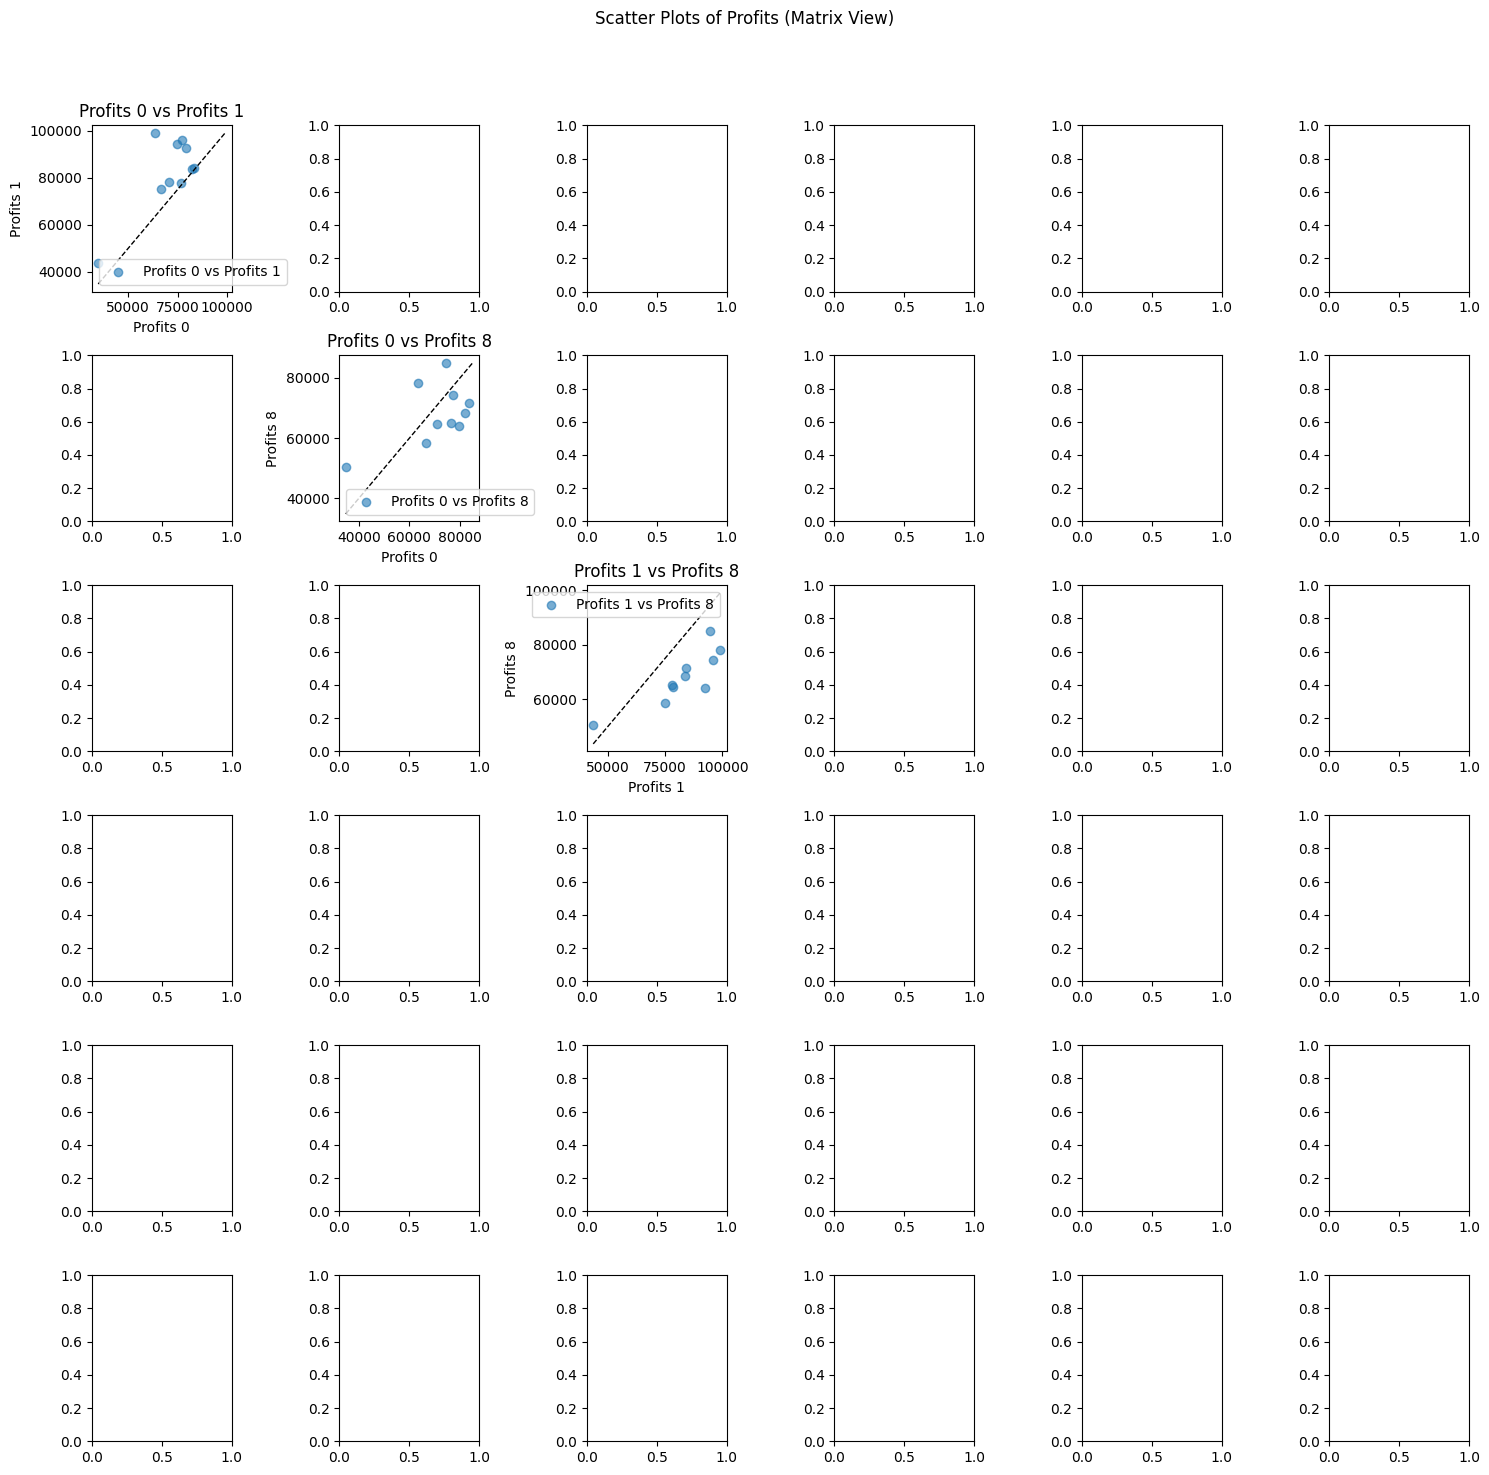

In [235]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_20_S1_202411261441.png


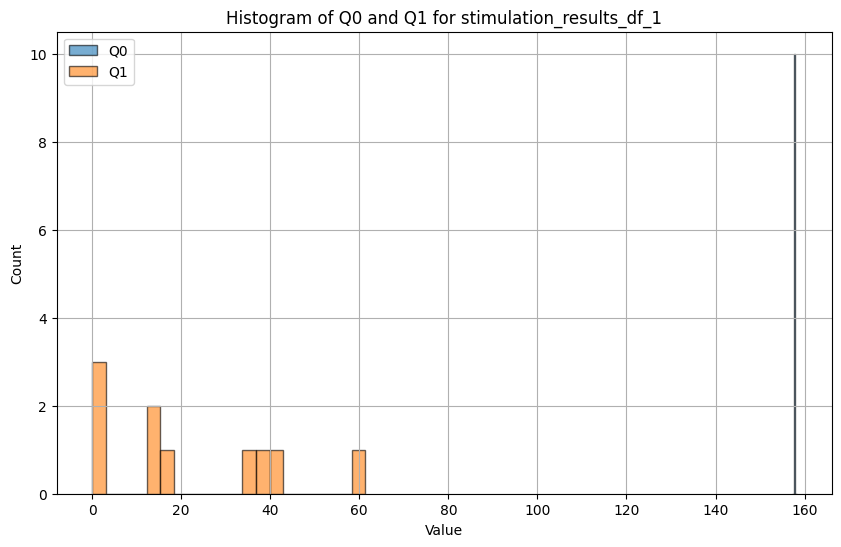

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_20_S8_202411261441.png


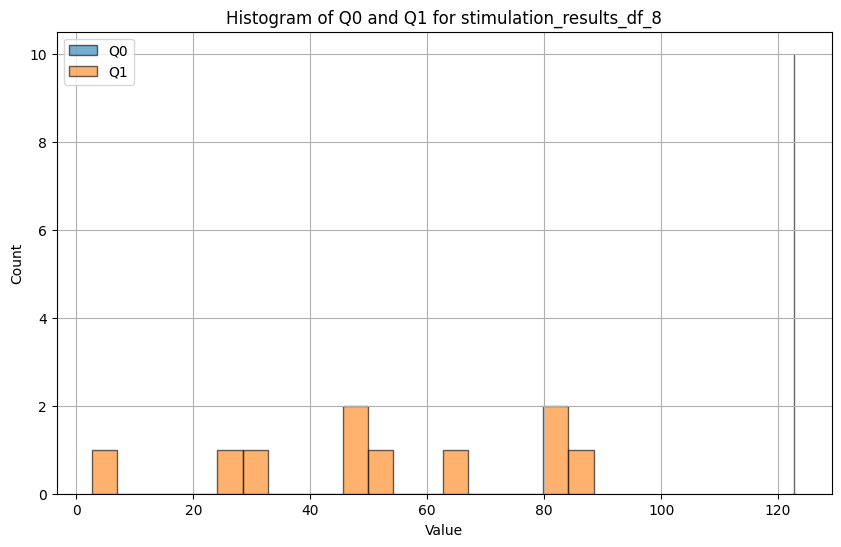

In [236]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_20_S1_202411261441.png


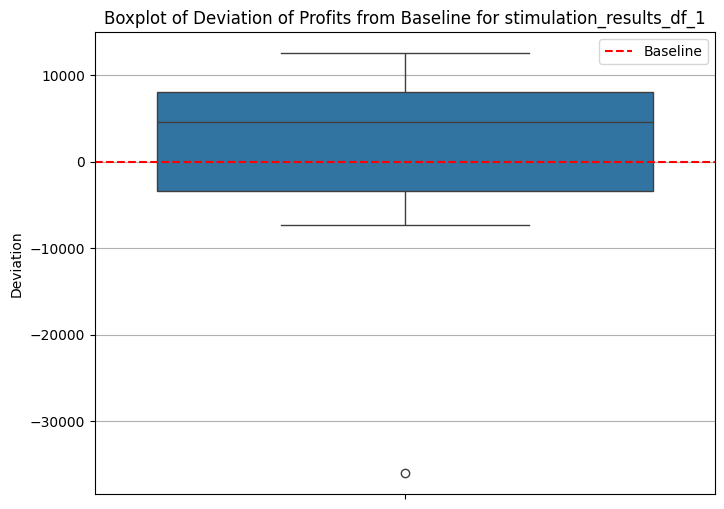

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_20_S2_202411261441.png


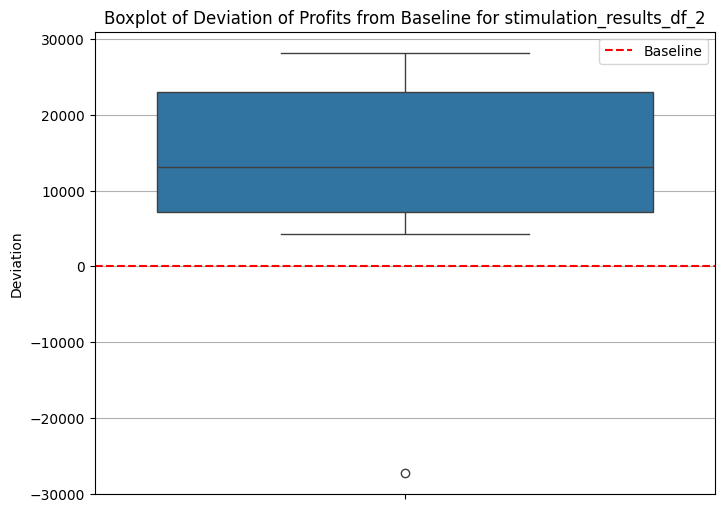

Skipping stimulation_results_df_3: Missing 'profits' column.
Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_20_S9_202411261441.png


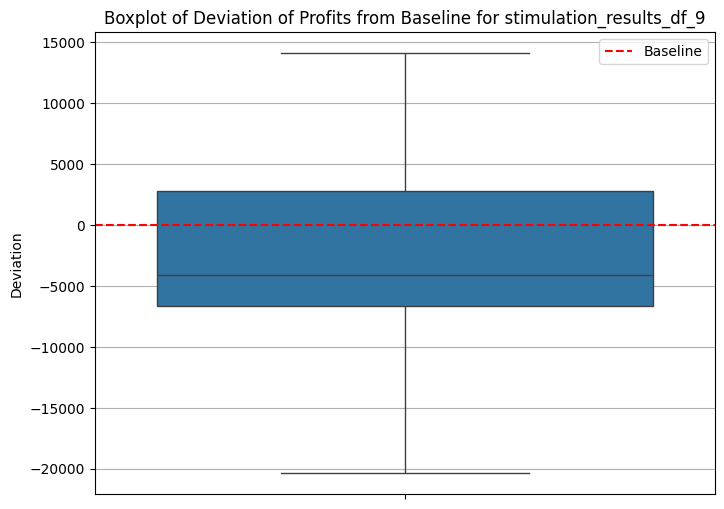

In [237]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 70874.1586454361
S1's profit: 82521.94427004398
S2's profit: -1
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: 84965.78039134499
Plot saved as plots/plot_relative_profit_deviation_train_med_with_holding_cost_20_20_202411261441.png


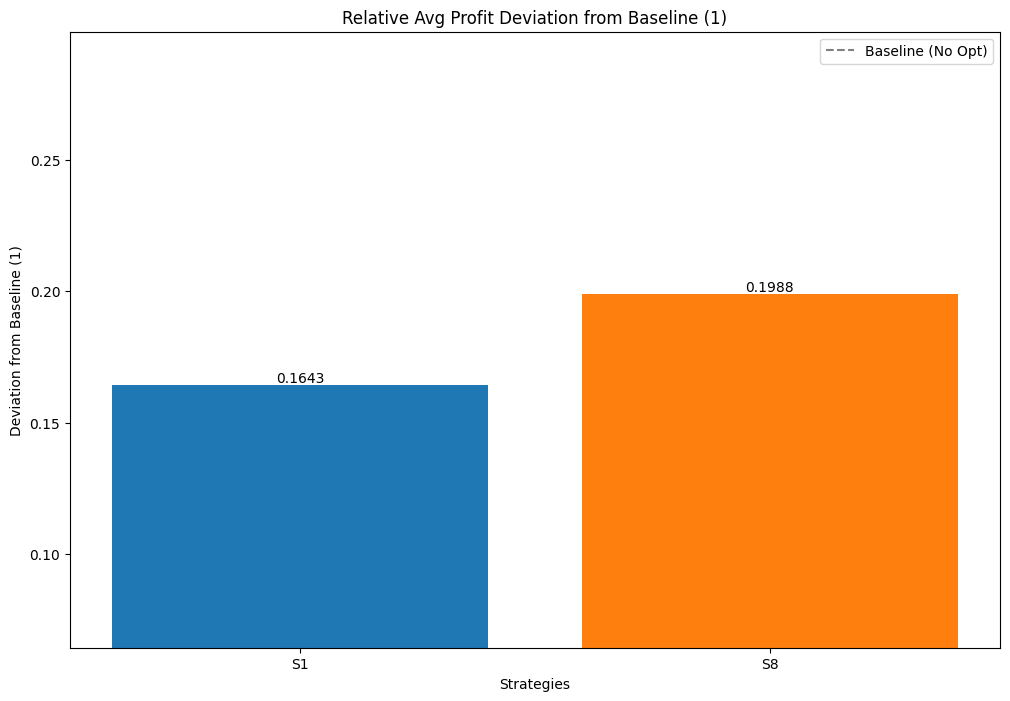

In [238]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [239]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [240]:
status = "test"

In [241]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 175.24908843677085
std of sum: 28.677047050944203
50.0 percentile of sum: 175.24908843677085
Q_star: 175.24908843677085


In [242]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (10, 8)


,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,203.047116,187.252041,179.167403,180.285901,195.735588,188.020244,184.229375,185.467327
1,188.708675,197.502099,229.515326,229.567167,231.266286,237.430292,224.937846,227.289038
2,200.035122,202.046362,213.774843,212.587385,215.582569,209.658991,214.927729,215.819362
3,188.777032,210.073331,188.625853,187.351444,202.463700,213.959862,218.618776,220.598738
4,181.207292,158.805438,170.233712,169.552409,180.209123,174.051305,176.324059,172.471105


### Run all the strategies


Baseline

In [243]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/10 with initial inventory Q_star=175.24908843677085
--------------------------------------------------
Day 1
Demand      : 30.44568030255325
Sales       : 30.44568030255325
Loss        : 0
Left        : 144.8034081342176
Inventory   : 144.8034081342176
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 16.69106023264269
Sales       : 16.69106023264269
Loss        : 0
Left        : 128.1123479015749
Inventory   : 128.1123479015749
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 20.980915120589653
Sales       : 20.980915120589653
Loss        : 0
Left        : 107.13143278098525
Inventory   : 107.13143278098525
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 23.954657711533788
Sales       : 23.954657711533788
Loss        : 0
Left        : 83.17677506945147


In [244]:
test_stimulation_df_baseline.head()

,losses,lefts,operation_profits,profits
0,12.237584,0.000000,87624.544218,81505.752011
1,51.562830,0.000000,87624.544218,61843.129311
2,36.252455,0.000000,87624.544218,69498.316541
3,46.317829,0.000000,87624.544218,64465.629712
4,0.000000,2.651294,86298.897127,84973.250036


S1

In [245]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.9, R: 8
Q_star 為 175.24908843677085
期初庫存 Q0: 157.72417959309377
重新估計量 Qk_hat: 184.22937543534164
訂貨量 Q1 為 26.505195842247872

第一階段：期初庫存 Q0: 157.72417959309377，需求量為 147.62804531604166，Sold_0 為 147.62804531604166，Left_0 為 10.096134277052101，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 36.60133011929997，需求量為 39.858627536102524，Sold_1 為 36.60133011929997，Left_1 為 0.0，Lost_1 為 3.257297416802551

統計結果：Sold 為 184.22937543534164, Lost 為 3.257297416802551 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 1628.6487084012756，Profit 為 90486.03900926955
----------------------------------------
這是第 2 筆模擬資料

F: 0.9, R: 8
Q_star 為 175.24908843677085
期初庫存 Q0: 157.72417959309377
重新估計量 Qk_hat: 224.93784589224754
訂貨量 Q1 為 67.21366629915377

第一階段：期初庫存 Q0: 157.72417959309377，需求量為 164.521050058455，Sold_0 為 157.72417959309377，Left_0 為 0.0，Lost_0 為 6.7968704653612235
第二階段：期初庫存 Q1+left_0 為 67.21366629915377，需求量為 62.290868192480616，Sold_1 為 62.290868192480616，Left_1 為 4.922798106673156，Lost_1 為 0

統計結果：Sold 

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
0,8,0.9,"[157.72417959309377, 157.72417959309377, 157.7...","[26.505195842247872, 67.21366629915377, 57.203...",89012.522878,3.582848,7.234821,94421.357144


S2

In [246]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

S3

In [247]:
results_df_3.head()

,R(T),average_losses,average_lefts,average_operation_profits,average_profits,beta_values,F_vars,Q0_vars,Q1_vars,tau_values


In [248]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_3

S4

In [249]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_4

S5

In [250]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

In [251]:
test_stimulation_results_df_5

S6

In [252]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

In [253]:
test_stimulation_results_df_6

S7

In [254]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

S8

In [255]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
0,7,0.7,"[122.6743619057396, 122.6743619057396, 122.674...","[65.3458824142171, 114.755929815164, 86.984628...",65529.192157,10.400538,10.400538,91012.511996


### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_med_with_holding_cost_20_20_202411261441.png


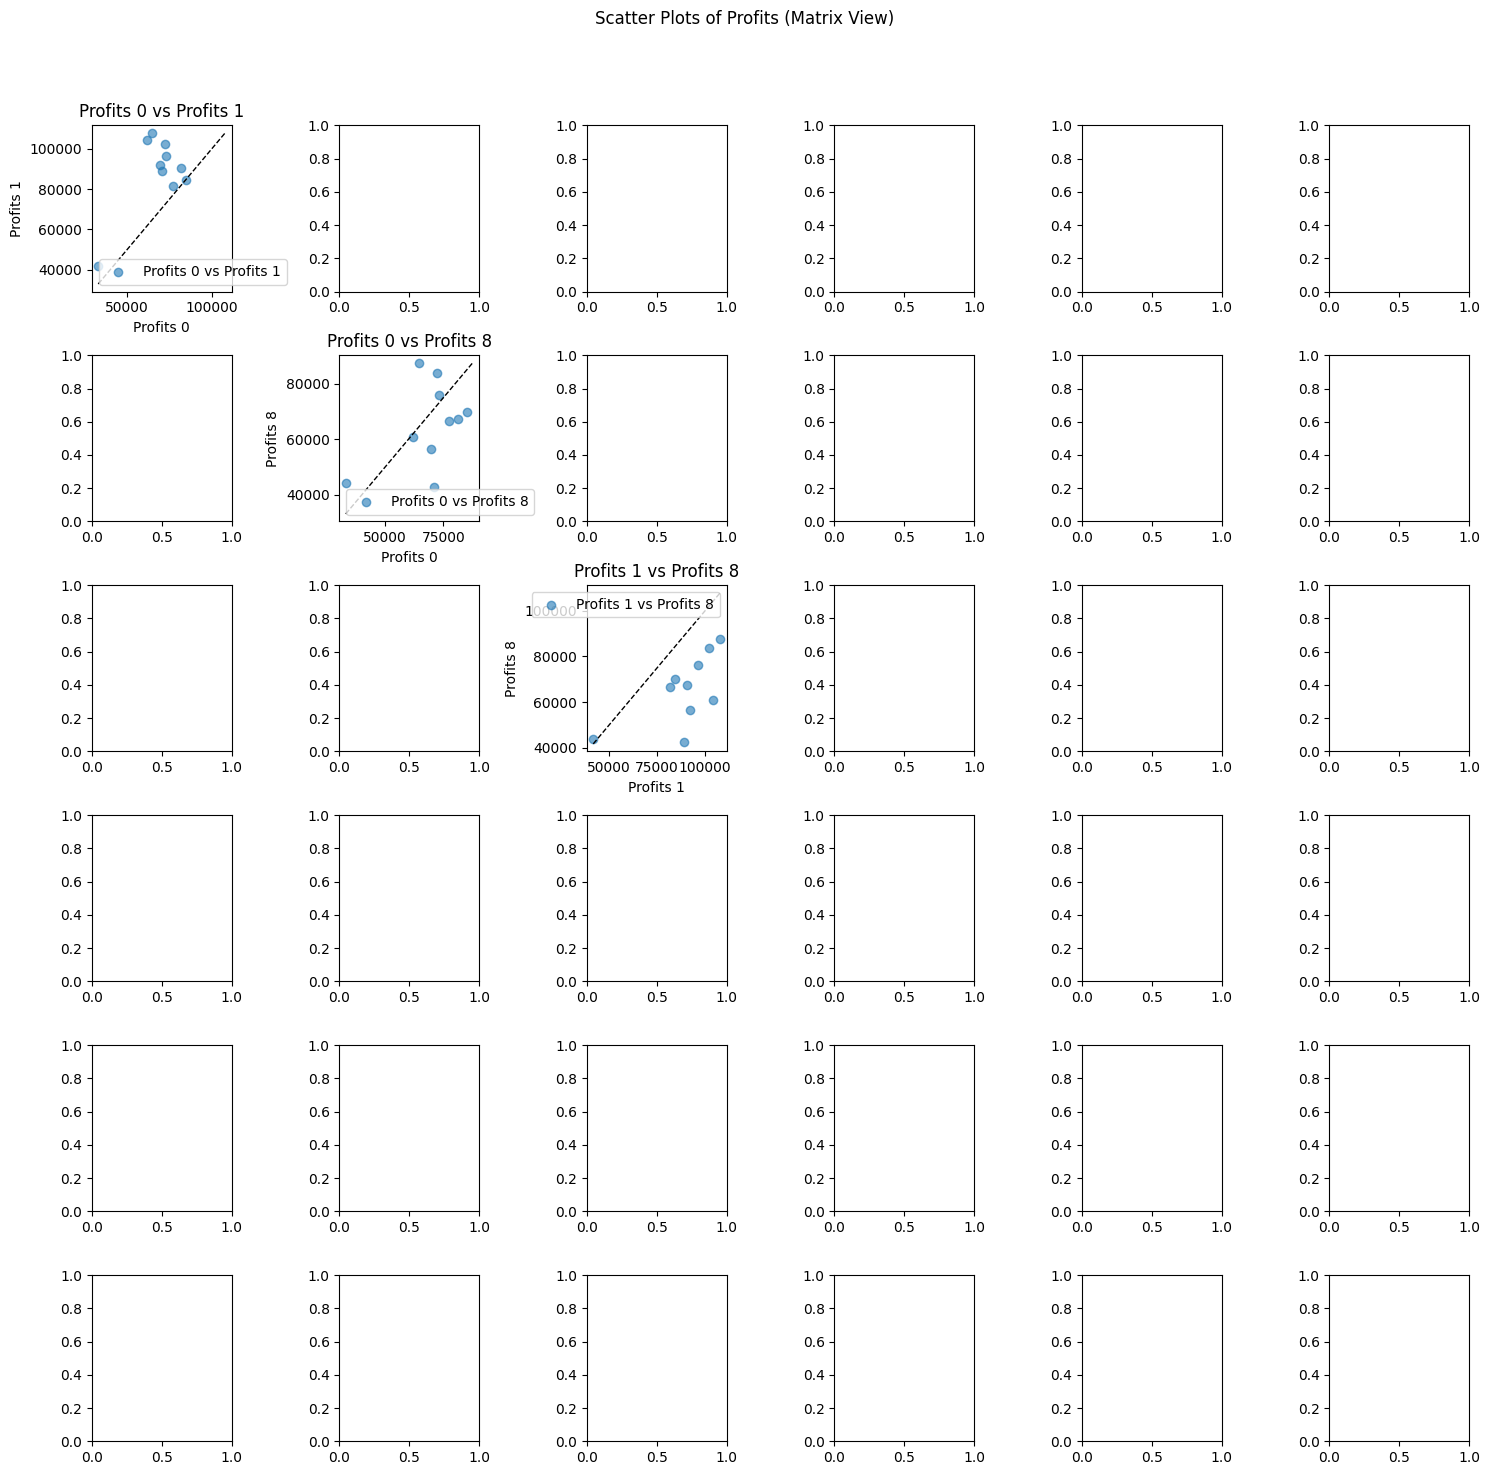

In [256]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 68894.33422046283
S1's profit: 89012.52287780863
S2's profit: -1
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: 65529.19215658844
Plot saved as plots/plot_relative_profit_deviation_test_med_with_holding_cost_20_20_202411261441.png


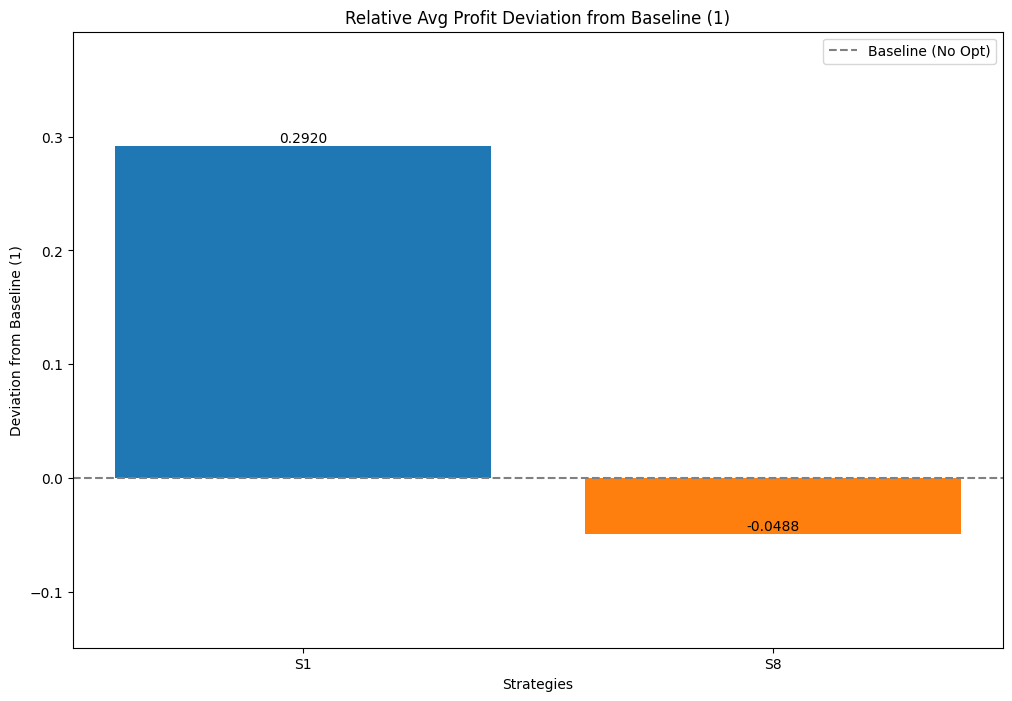

In [257]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_20_S1_202411261441.png


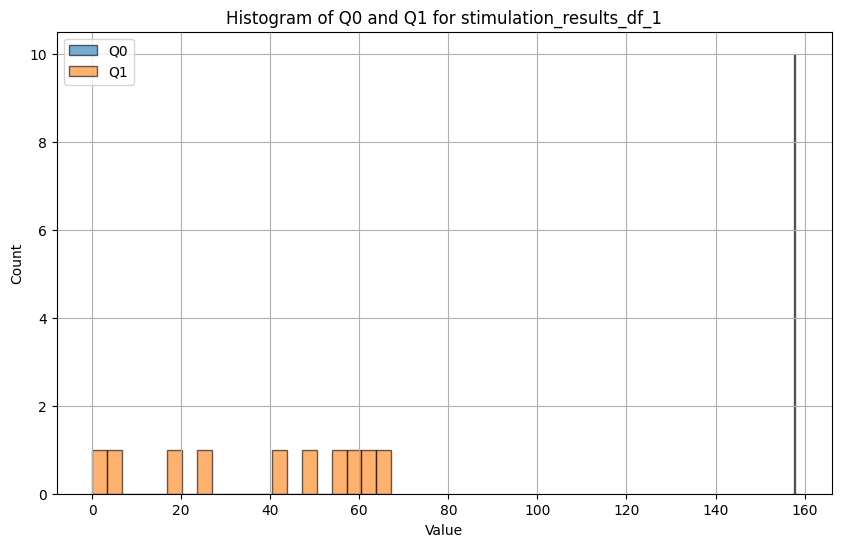

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_20_S8_202411261441.png


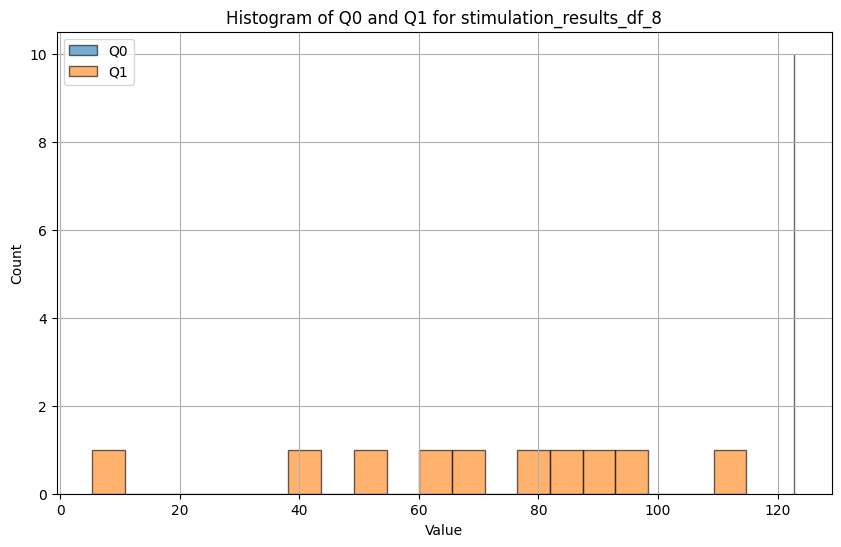

In [258]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_20_S1_202411261441.png


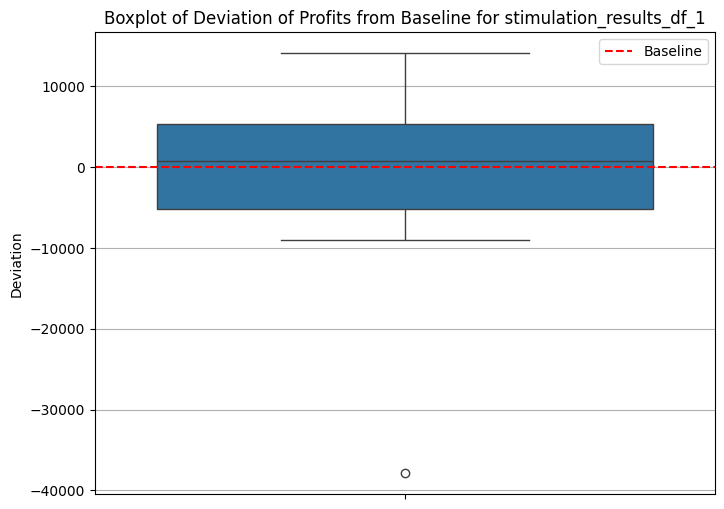

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_20_S2_202411261441.png


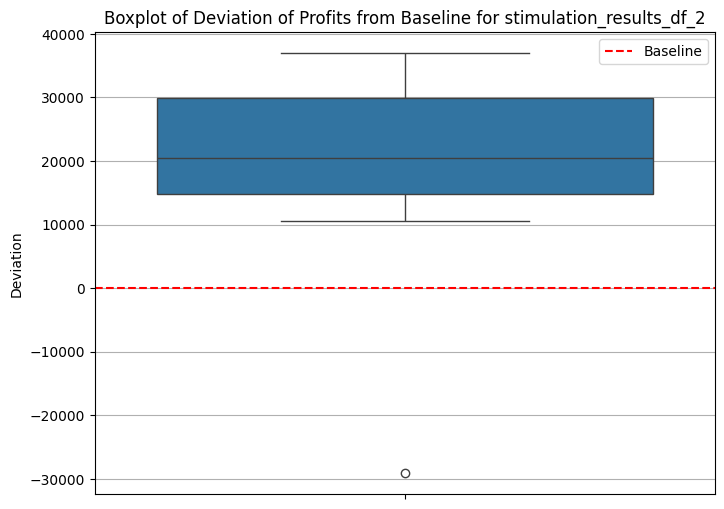

Skipping stimulation_results_df_3: Missing 'profits' column.
Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_20_S9_202411261441.png


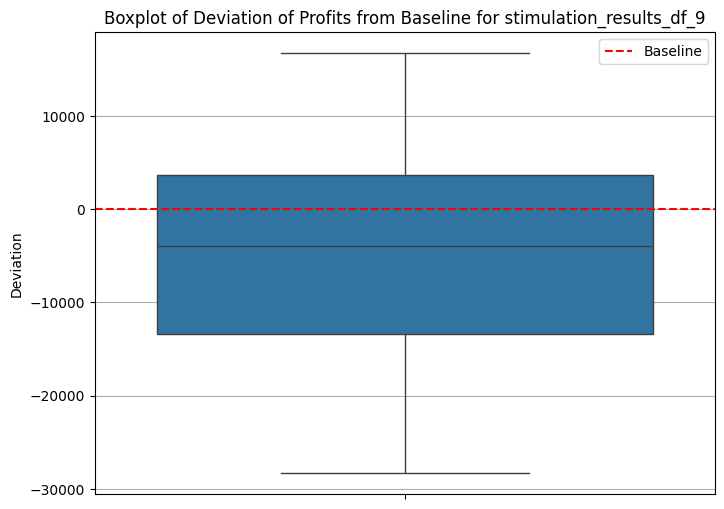

In [259]:
plot_profits_deviation_box_plot(f"{status}_{model_prefix}", dfs, baseline_avg_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_med_with_holding_cost_20_20_202411261441.png


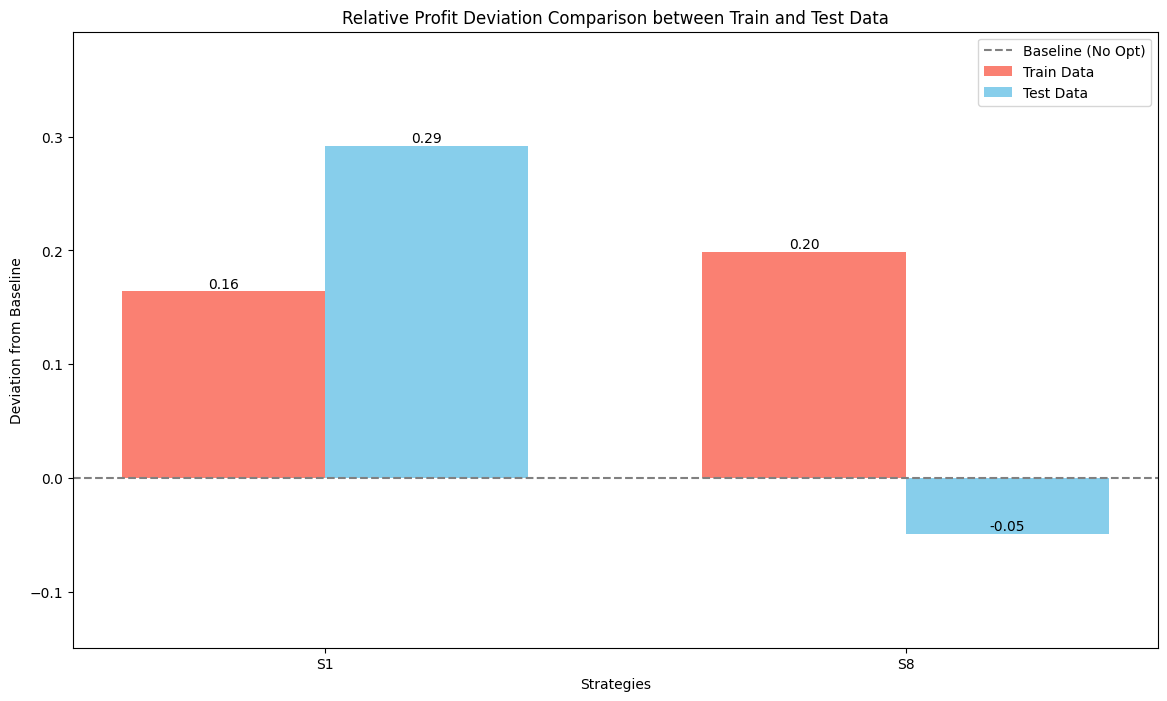

In [260]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [261]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]

In [262]:
# # 測試 HC 與 最佳 R, F 的變化

# def visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits):
#     plt.figure(figsize=(15, 10))

#     # Plot R changes
#     plt.subplot(3, 1, 1)
#     plt.plot(holding_cost_list, best_Rs, marker="o", label="Best R")
#     plt.title("HC vs. Best R(T)")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("R(T)")
#     plt.grid(True)
#     plt.legend()

#     # Plot F changes
#     plt.subplot(3, 1, 2)
#     plt.plot(holding_cost_list, best_Fs, marker="o", color="orange", label="Best F")
#     plt.title("HC vs. Best F")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.legend()

#     # Plot profits
#     plt.subplot(3, 1, 3)
#     plt.plot(
#         holding_cost_list,
#         best_profits,
#         marker="o",
#         color="green",
#         label="Average Profits",
#     )
#     plt.title("HC vs. Average Profits")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("Average Profits")
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# holding_cost_list = [x for x in range(0, 1050, 50)]
# margins = [
#     {
#         "type": "low",
#         "price": 1000,
#         "cost": 800,
#         "salvage_value": 0,
#     },
#     {
#         "type": "med",
#         "price": 1000,
#         "cost": 500,
#         "salvage_value": 0,
#     },
#     {
#         "type": "high",
#         "price": 1000,
#         "cost": 200,
#         "salvage_value": 0,
#     },
# ]

# for margin in margins:

#     price = margin["price"]
#     cost = margin["cost"]
#     salvage_value = margin["salvage_value"]

#     service_lv = calculate_service_level(
#         salvage_value=salvage_value, cost=cost, price=price
#     )
#     Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)

#     best_Rs = []
#     best_Fs = []
#     best_profits = []

#     for holding_cost in holding_cost_list:

#         results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#             assigned_Ts=ASSIGNED_TS,
#             assigned_Fs=ASSIGNED_FS,
#             cost=cost,
#             price=price,
#             salvage_value=salvage_value,
#             Qk_hat_df=Qk_hat_df_train,
#             demand_df_train=demand_df_train,
#             Q_star=Q_star,
#             holding_cost=holding_cost,
#         )

#         best_Rs.append(results_df_8.iloc[0]["R(T)"])
#         best_Fs.append(results_df_8.iloc[0]["F"])
#         best_profits.append(results_df_8.iloc[0]["average_profits"])

#     print(f"Now at {margin['type']}...\n")
#     visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits)